# STROKE PREDICTION PROJECT

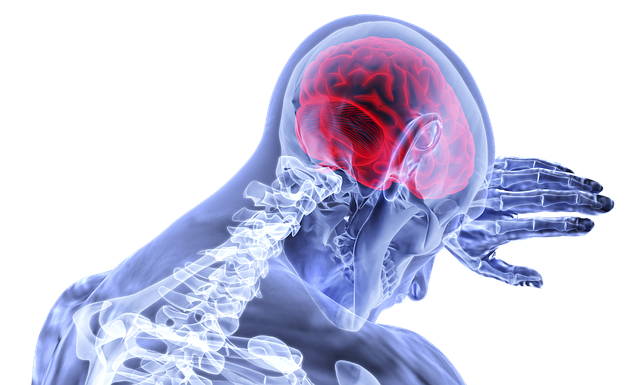

In [2]:
Image('C:/Users/lucas/Documents/MeusProjetos/stroke_prediction/image/stroke.png')

Context:

According to the World Health Organization (WHO) stroke is the 2nd leading cause of death globally, responsible for approximately 11% of total deaths.
This dataset is used to predict whether a patient is likely to get stroke based on the input parameters like gender, age, various diseases, and smoking status. Each row in the data provides relavant information about the patient.

Attribute Information:

1) id: unique identifier
2) gender: "Male", "Female" or "Other"
3) age: age of the patient
4) hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
5) heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
6) ever_married: "No" or "Yes"
7) work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
8) Residence_type: "Rural" or "Urban"
9) avg_glucose_level: average glucose level in blood
10) bmi: body mass index
11) smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
12) stroke: 1 if the patient had a stroke or 0 if not

*Note: "Unknown" in smoking_status means that the information is unavailable for this patient

Source: https://www.kaggle.com/fedesoriano/stroke-prediction-dataset

## 0.0. INITIAL

### 0.1. Imports

In [3]:
import pandas as pd
import math
import numpy as np
import seaborn as sns
import matplotlib
from IPython.core.display       import HTML
from IPython.display            import Image
from tabulate                   import tabulate
from sklearn                    import model_selection      as ms
from scipy                      import stats                as ss
from sklearn.preprocessing      import RobustScaler, MinMaxScaler, LabelEncoder
from imblearn.combine           import SMOTETomek

from sklearn.linear_model       import LogisticRegression
from sklearn.ensemble           import RandomForestClassifier
import xgboost as xgb
from sklearn                    import metrics
from scipy                      import stats    as ss
from boruta                     import BorutaPy
from sklearn.model_selection    import cross_val_score, cross_validate, StratifiedKFold

### 0.2. Functions

In [4]:
# Função para definição de alguns parâmetros do notebook, como tamanho de gráficos, número de linhas do output, etc.
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [20, 15]
    plt.rcParams['font.size'] = 16
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = 100
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    sns.set_theme(context = 'notebook', palette = 'Paired')

def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

In [5]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


### 0.3. Data Load

In [6]:
df_raw = pd.read_csv('C:/Users/lucas/Documents/MeusProjetos/stroke_prediction/data/healthcare-dataset-stroke-data.csv', low_memory = False)

In [7]:
df_raw.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## 1.0. DATA DESCRIPTION

In [8]:
df1 = df_raw.copy()

### 1.1. Column's Names

In [9]:
df1.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

### 1.2. Data Dimensions

In [10]:
print('Number of Rows: {}'.format(df1.shape[0]))

print('Number of Columns: {}'.format(df1.shape[1]))

Number of Rows: 5110
Number of Columns: 12


### 1.3. Data Types

In [11]:
# Não se faz necessária a mudança de tipo em nenhuma variável
df1.dtypes

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

### 1.4. Check NA

In [12]:
df1.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [13]:
df1[df1['bmi'].isna() ]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
8,27419,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1
13,8213,Male,78.0,0,1,Yes,Private,Urban,219.84,NaN,Unknown,1
19,25226,Male,57.0,0,1,No,Govt_job,Urban,217.08,NaN,Unknown,1
27,61843,Male,58.0,0,0,Yes,Private,Rural,189.84,NaN,Unknown,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5039,42007,Male,41.0,0,0,No,Private,Rural,70.15,NaN,formerly smoked,0
5048,28788,Male,40.0,0,0,Yes,Private,Urban,191.15,NaN,smokes,0
5093,32235,Female,45.0,1,0,Yes,Govt_job,Rural,95.02,NaN,smokes,0
5099,7293,Male,40.0,0,0,Yes,Private,Rural,83.94,NaN,smokes,0


### 1.5. Replace NA

In [14]:
round(df1['bmi'].mean(), 1)

28.9

In [15]:
# Decidi substituir os valores NA pela média de forma a preservar os outros dados, que são importantes
df1 = df1.fillna(round(df1['bmi'].mean(), 1))

In [16]:
df1.isna().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [17]:
df1.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.9,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [18]:
# Verificação de dados iguais a zero, algumas colunas apresentaram os mesmos porém está de acordo com o esperado
# pois tratam-se de variáveis binárias (0 ou 1)
print("# Linhas no dataframe {0}".format(len(df1)))

for i in range(len(df1.columns)):

    j = df1.columns[i]
    print("# Linhas missing {0} : {1}".format(j, len(df1.loc[df1[j] == 0])))

# Linhas no dataframe 5110
# Linhas missing id : 0
# Linhas missing gender : 0
# Linhas missing age : 0
# Linhas missing hypertension : 4612
# Linhas missing heart_disease : 4834
# Linhas missing ever_married : 0
# Linhas missing work_type : 0
# Linhas missing Residence_type : 0
# Linhas missing avg_glucose_level : 0
# Linhas missing bmi : 0
# Linhas missing smoking_status : 0
# Linhas missing stroke : 4861


### 1.6. Descriptive Statistical

In [19]:
# Dividindo as variáveis em categóricas e numéricas para análise
num_attr = df1.select_dtypes(include = ['int64', 'float64'])
cat_attr = df1.select_dtypes(exclude = ['int64', 'float64'])

#### 1.6.1 Numerical Attributes

In [20]:
# Central Tendency - mean, median 
ct1 = pd.DataFrame(num_attr.apply(np.mean)).T
ct2 = pd.DataFrame(num_attr.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attr.apply(np.std)).T 
d2 = pd.DataFrame(num_attr.apply(min)).T 
d3 = pd.DataFrame(num_attr.apply(max)).T 
d4 = pd.DataFrame(num_attr.apply(lambda x: x.max() - x.min())).T 
d5 = pd.DataFrame(num_attr.apply(lambda x: x.skew())).T 
d6 = pd.DataFrame(num_attr.apply(lambda x: x.kurtosis())).T 

# Concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m


,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,67.00,72940.00,72873.00,36517.829354,36932.000,21159.650905,-0.019913,-1.212368
1,age,0.08,82.00,81.92,43.226614,45.000,22.610434,-0.137059,-0.991010
2,hypertension,0.00,1.00,1.00,0.097456,0.000,0.296578,2.715392,5.375456
3,heart_disease,0.00,1.00,1.00,0.054012,0.000,0.226041,3.947244,13.586052
4,avg_glucose_level,55.12,271.74,216.62,106.147677,91.885,45.279129,1.572284,1.680479
5,bmi,10.30,97.60,87.30,28.893503,28.400,7.697265,1.076612,3.622912
6,stroke,0.00,1.00,1.00,0.048728,0.000,0.215299,4.193284,15.589736


c:\Users\lucas\Documents\MeusProjetos\stroke_prediction\stroke_prediction_venv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\lucas\Documents\MeusProjetos\stroke_prediction\stroke_prediction_venv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\lucas\Documents\MeusProjetos\stroke_prediction\stroke_prediction_venv\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and

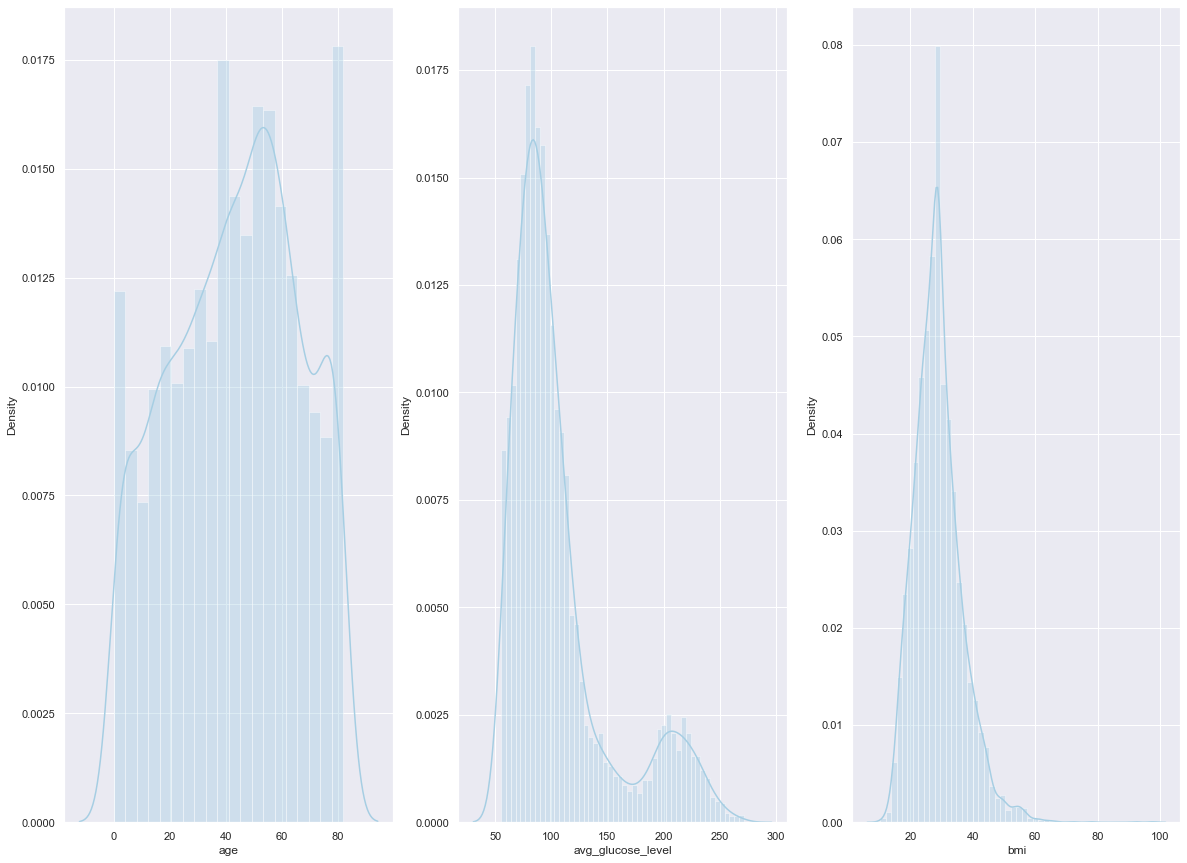

In [21]:
plt.subplot(1, 3, 1)
sns.distplot(df1['age']);

plt.subplot(1, 3, 2)
sns.distplot(df1['avg_glucose_level']);


plt.subplot(1, 3, 3)
sns.distplot(df1['bmi']);

#### 1.6.2 Categorical Attributes

In [22]:
# Discovering how many types each categorical variable has
cat_attr.apply(lambda x: x.unique().shape[0])

gender            3
ever_married      2
work_type         5
Residence_type    2
smoking_status    4
dtype: int64

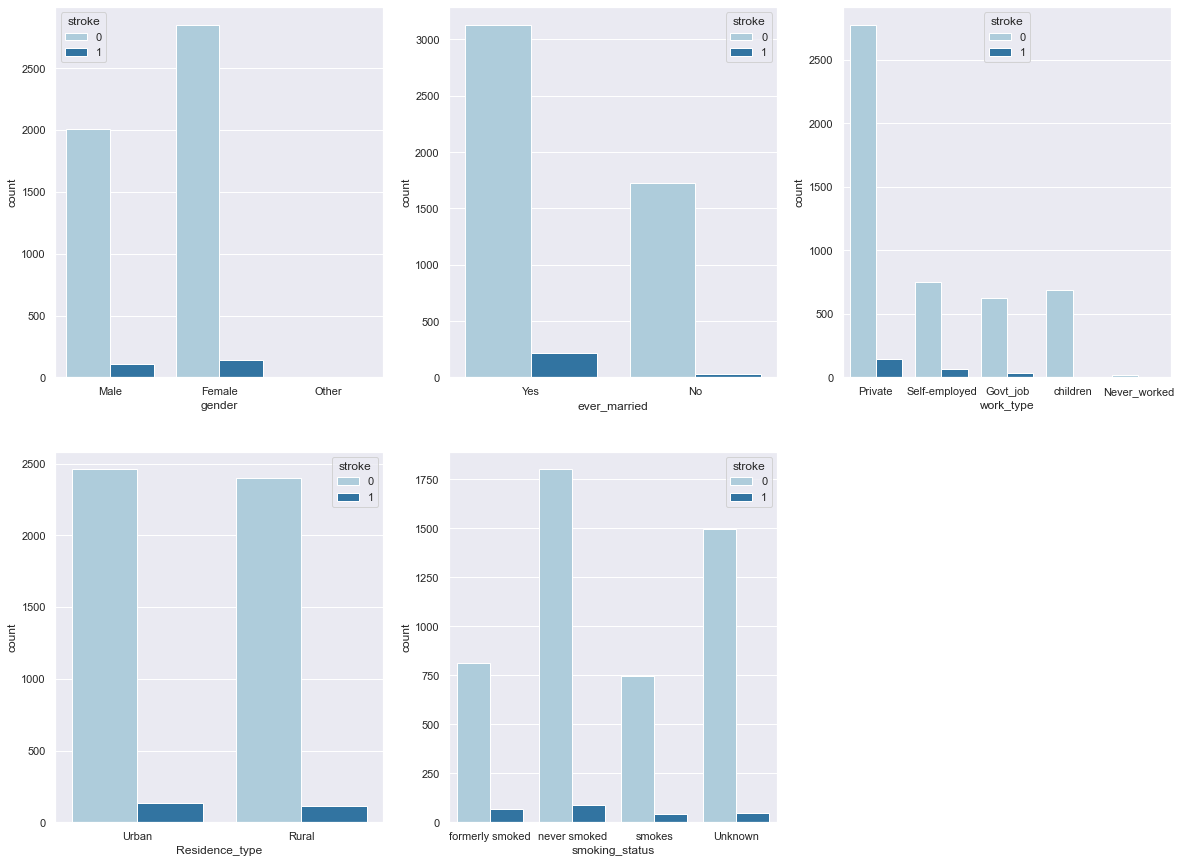

In [23]:
plt.subplot(2, 3, 1)
sns.countplot(data = df1, x = 'gender', hue = 'stroke');

plt.subplot(2, 3, 2)
sns.countplot(data = df1, x = 'ever_married', hue = 'stroke');

plt.subplot(2, 3, 3)
sns.countplot(data = df1, x = 'work_type', hue = 'stroke');

plt.subplot(2, 3, 4)
sns.countplot(data = df1, x = 'Residence_type', hue = 'stroke');

plt.subplot(2, 3, 5)
sns.countplot(data = df1, x = 'smoking_status', hue = 'stroke');

## 2.0. FEATURE ENGINEERING

In [24]:
df2 = df1.copy()

### 2.1. Hypothesis Mind Map

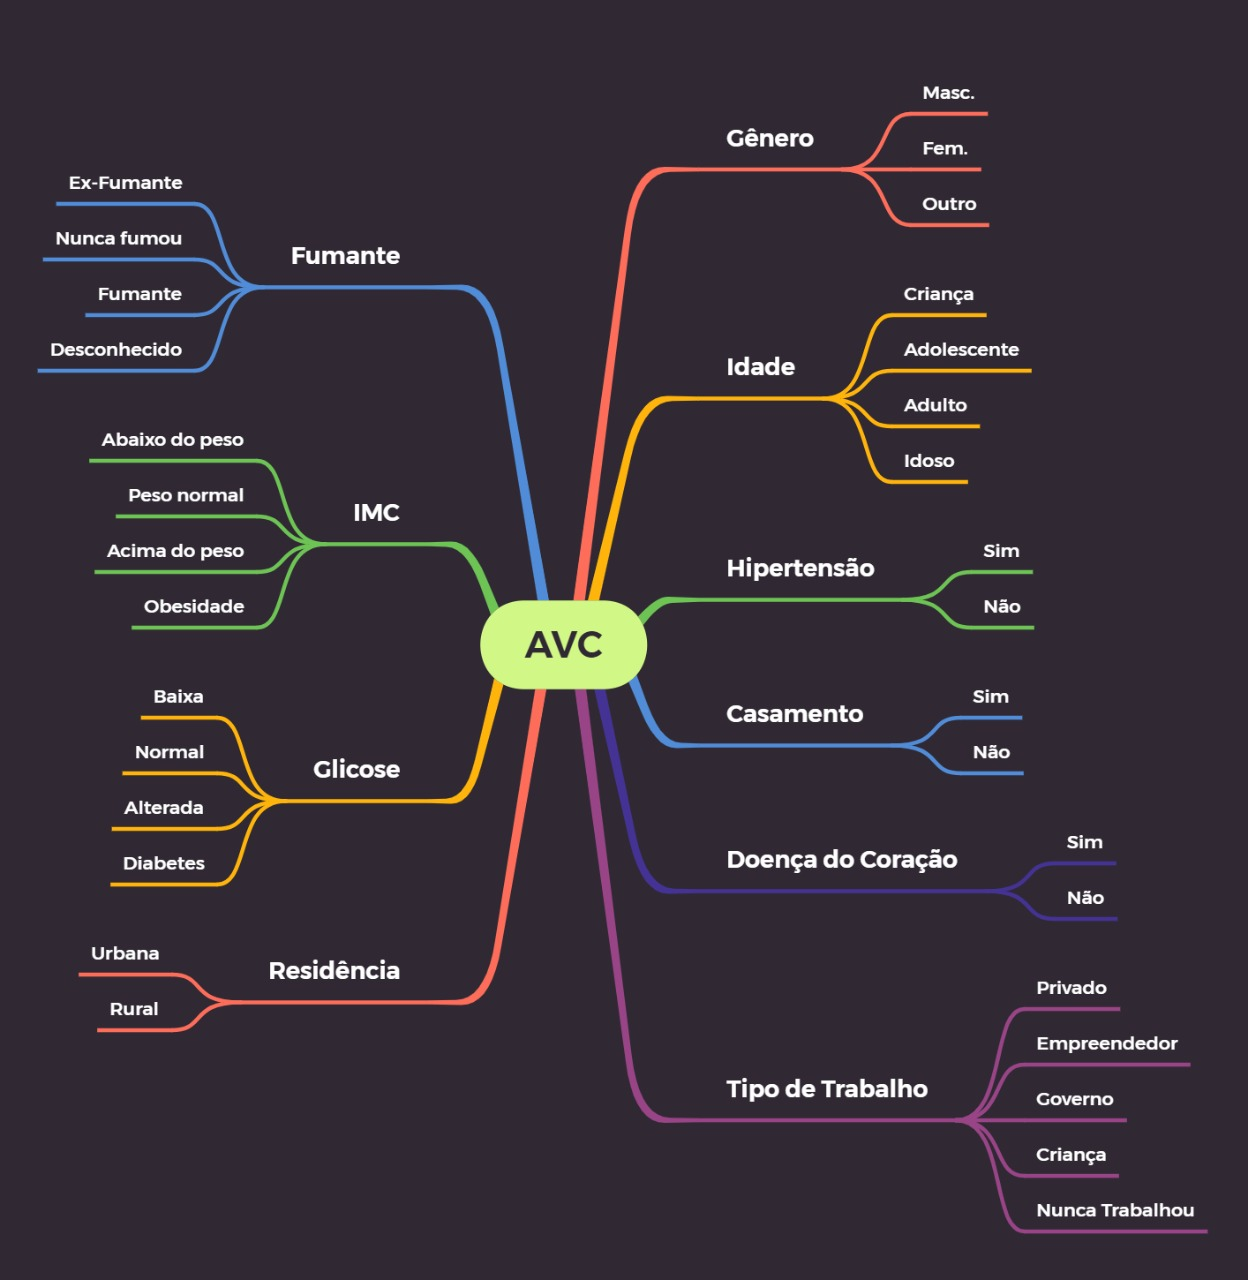

In [25]:
# Mapa mental de hipóteses
Image('C:/Users/lucas/Documents/MeusProjetos/stroke_prediction/image/hmm.jpeg')

### 2.2. Hypothesis Creation

Hipóteses Gênero

1 - Homens têm mais chances de ter AVC que mulheres 

Hipóteses Fumante

1 - Fumantes têm mais chances de ter AVC que os demais

2 - Pessoas que nunca fumaram têm menos chances de ter AVC que os demais

Hipóteses Idade

1 - Crianças têm menos chances de ter AVC que os demais

2 - Idosos têm mais chances de ter AVC que os demais

Hipóteses IMC

1 - Pessoas obesas têm mais chances de ter AVC que os demais

2 - Pessoas com peso normal têm menos chances de ter AVC que os demais

Hipóteses Glicose

1 - Pessoas diabéticas têm mais chances de ter AVC que os demais

2 - Pessoas com glicose normal têm menos chances de ter AVC que os demais

Hipóteses Casamento

1 - Pessoas casadas têm mais chances de ter AVC 

Hipóteses Hipertensão

1 - Pessoas hipertensas têm mais chances de ter AVC

Hipóteses Doença do Coração

1 - Pessoas cardíacas têm mais chances de ter AVC

Hipóteses Residência

1 - Pessoas que moram na zona urbana têm mais chances de ter AVC

Hipóteses Tipo de Trabalho

1 - Pessoas empreendedoras têm mais chances de ter AVC que os demais

2 - Crianças têm menos chances de ter AVC que os demais

### 2.3. Feature Engineering

In [26]:
df2.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.9,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [27]:
# Dividindo o IMC (BMI) em categorias que possibilitem a análise e validação das hipóteses
df2['weight_status'] = df2['bmi'].apply(lambda x: 'underweight'     if      x < 18.5                else
                                                  'normal_weight'   if      (x >= 18.5) & (x <= 24.9)   else
                                                  'overweight'      if      (x > 24.9) & (x < 30)       else
                                                  'obesity')

In [28]:
# Dividindo o nível de glicose em categorias que possibilitem a análise e validação das hipóteses
df2['glucose_status'] = df2['avg_glucose_level'].apply(lambda x: 'low'          if      x <= 70                else
                                                                 'normal'       if      (x > 70) & (x < 100)   else
                                                                 'prediabetes'  if      (x >= 100) & (x <= 125)       else
                                                                 'diabetes')

In [29]:
# Dividindo as idades em categorias que possibilitem a análise e validação das hipóteses
df2['age_group'] = df2['age'].apply(lambda x:   'children'          if      x <= 16                else
                                                'adult'             if      (x > 16) & (x < 60)       else
                                                'elderly')

## 3.0. VARIABLE FILTERING

In [30]:
df3 = df2.copy()

## 4.0. EXPLORATORY DATA ANALYSIS

In [31]:
df4 = df3.copy()

### 4.1. Univariate analysis

#### 4.1.1 Response Variable

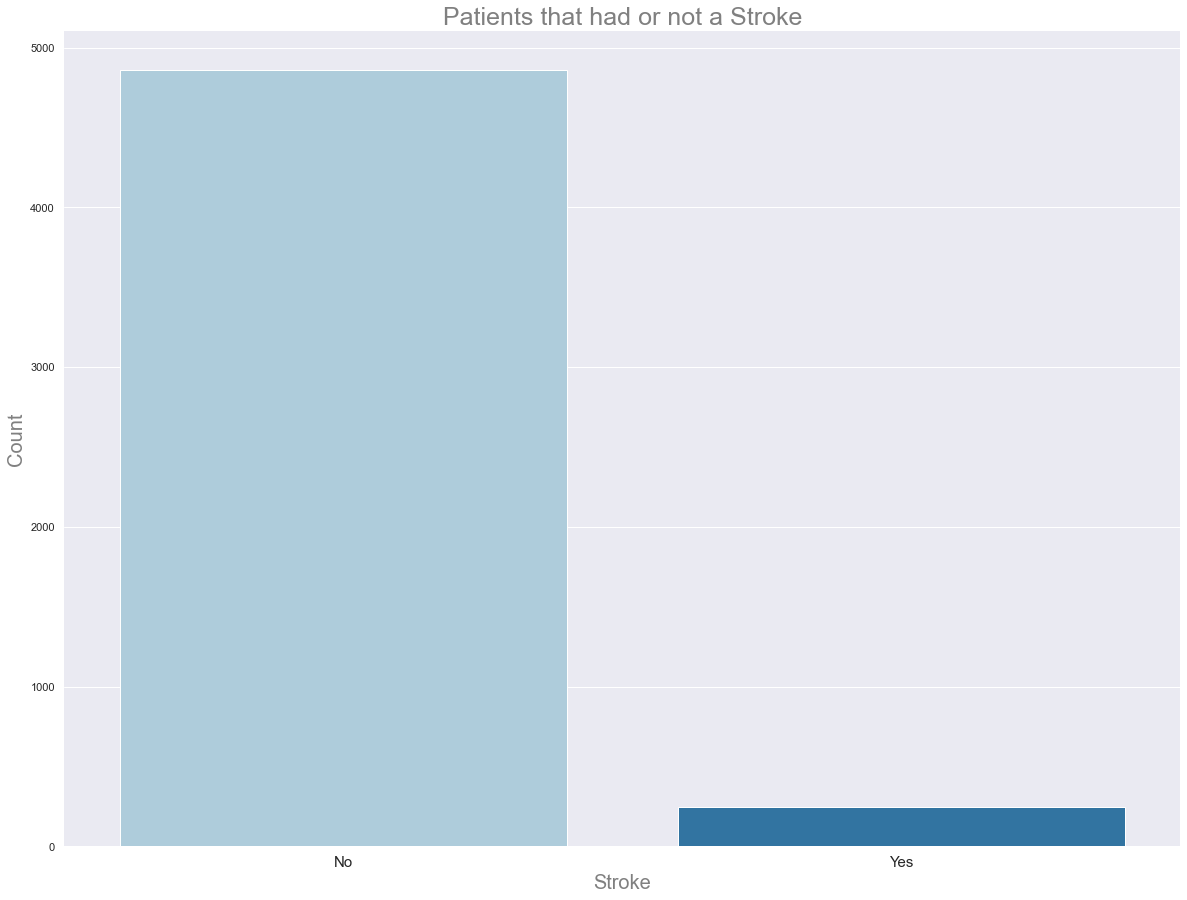

In [32]:
# Percebe-se um significativo desbalanceamento na variável resposta
sns.countplot(data = df4, x = 'stroke');
sns.set_style('whitegrid')
plt.title('Patients that had or not a Stroke', size = 25, color = 'grey')
plt.xlabel('Stroke', size = 20, color = 'grey')
plt.xticks(np.arange(2), labels=['No','Yes'], size = 15)
sns.set_style("whitegrid")
sns.despine( bottom = True, left = True)
plt.ylabel("Count", size = 20, color = 'grey');

#### 4.1.1 Numerical Variables

c:\Users\lucas\Documents\MeusProjetos\stroke_prediction\stroke_prediction_venv\lib\site-packages\pandas\plotting\_matplotlib\tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


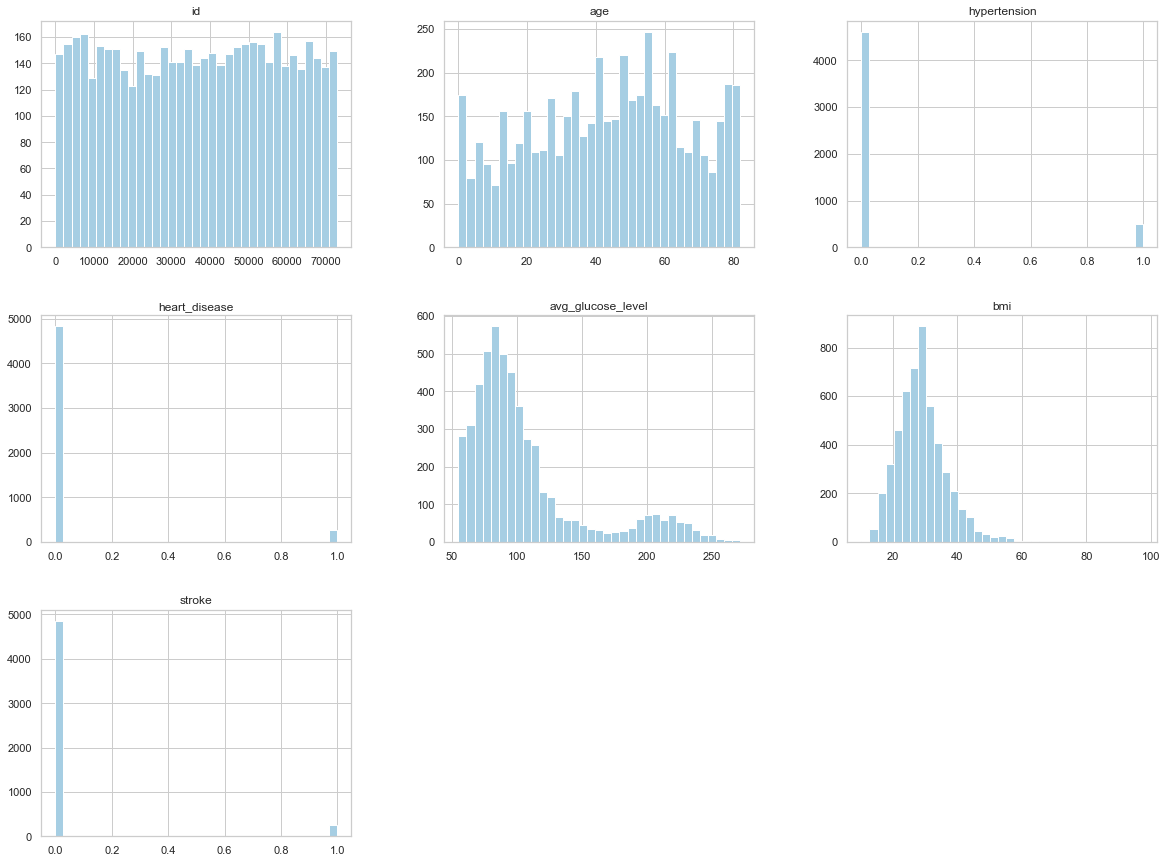

In [33]:
num_attr.hist(bins = 35);

#### 4.1.1 Categorical Variables

<AxesSubplot:xlabel='age_group', ylabel='count'>

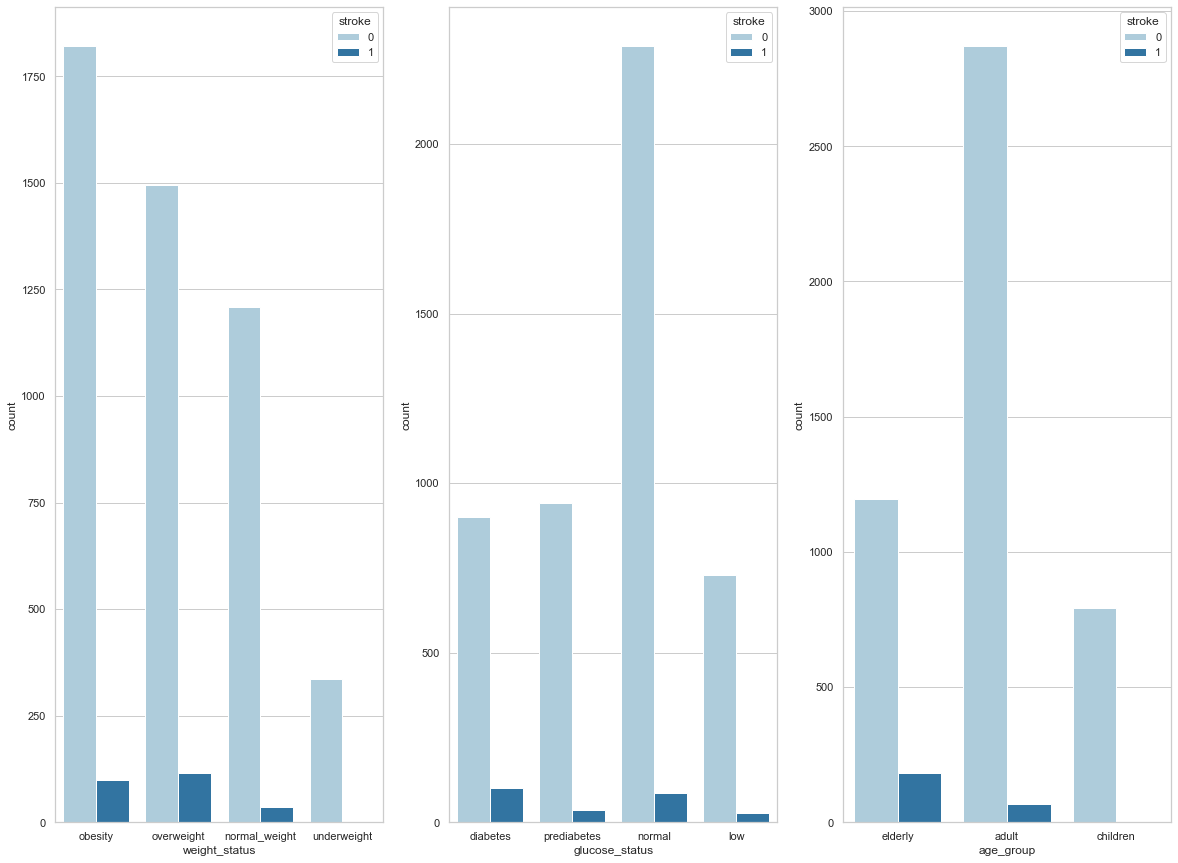

In [34]:
# weight_status
plt.subplot(1, 3, 1)
sns.countplot(data = df4, x = 'weight_status', hue = 'stroke');

# glucose_status
plt.subplot(1, 3, 2)
sns.countplot(data = df4, x = 'glucose_status', hue = 'stroke');

# age_group
plt.subplot(1, 3, 3)
sns.countplot(data = df4, x = 'age_group', hue = 'stroke');


### 4.2. Bivariate analysis - Hypothesis Validation

#### Hipótese 1 - Homens têm mais chances de ter AVC que mulheres 

FALSA - Mulheres tiveram mais AVC que homens

In [35]:
aux = df4[df4['stroke'] == 1][['gender', 'stroke']].groupby('gender').sum().reset_index().sort_values(by = 'stroke', ascending = False)
aux

,gender,stroke
0,Female,141
1,Male,108


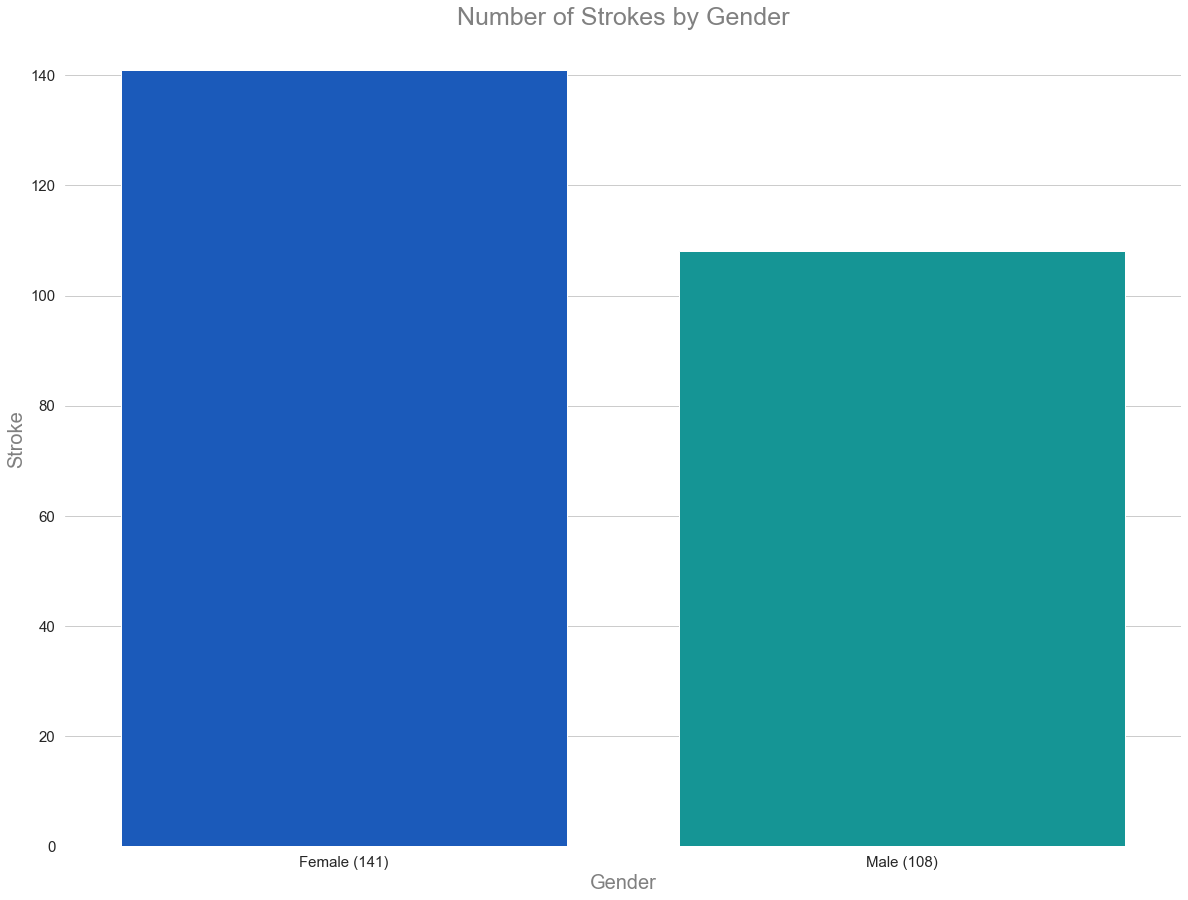

In [36]:
sns.barplot(x = 'gender', y = 'stroke', data = aux, palette = 'winter');
plt.title('Number of Strokes by Gender', size = 25, color = 'grey')
sns.despine(bottom = True, left = True)
plt.xlabel("Gender", size = 20, color = 'grey')
plt.ylabel("Stroke", size = 20, color = 'grey')
plt.xticks(np.arange(2), ['Female (141)', 'Male (108)'], size = 15)
plt.yticks(size = 15);

#### Hipótese 2 - Fumantes têm mais chances de ter AVC que os demais 

FALSA - Fumantes tiveram MENOS AVC

#### Hipótese 3 - Pessoas que nunca fumaram têm menos chances de ter AVC que os demais

FALSA - Pessoas que nunca fumaram tiveram MAIS AVC

In [37]:
aux1 = df4[df4['stroke'] == 1][['smoking_status', 'stroke']].groupby('smoking_status').sum().reset_index().sort_values(by = 'stroke', ascending = False)
aux1

,smoking_status,stroke
2,never smoked,90
1,formerly smoked,70
0,Unknown,47
3,smokes,42


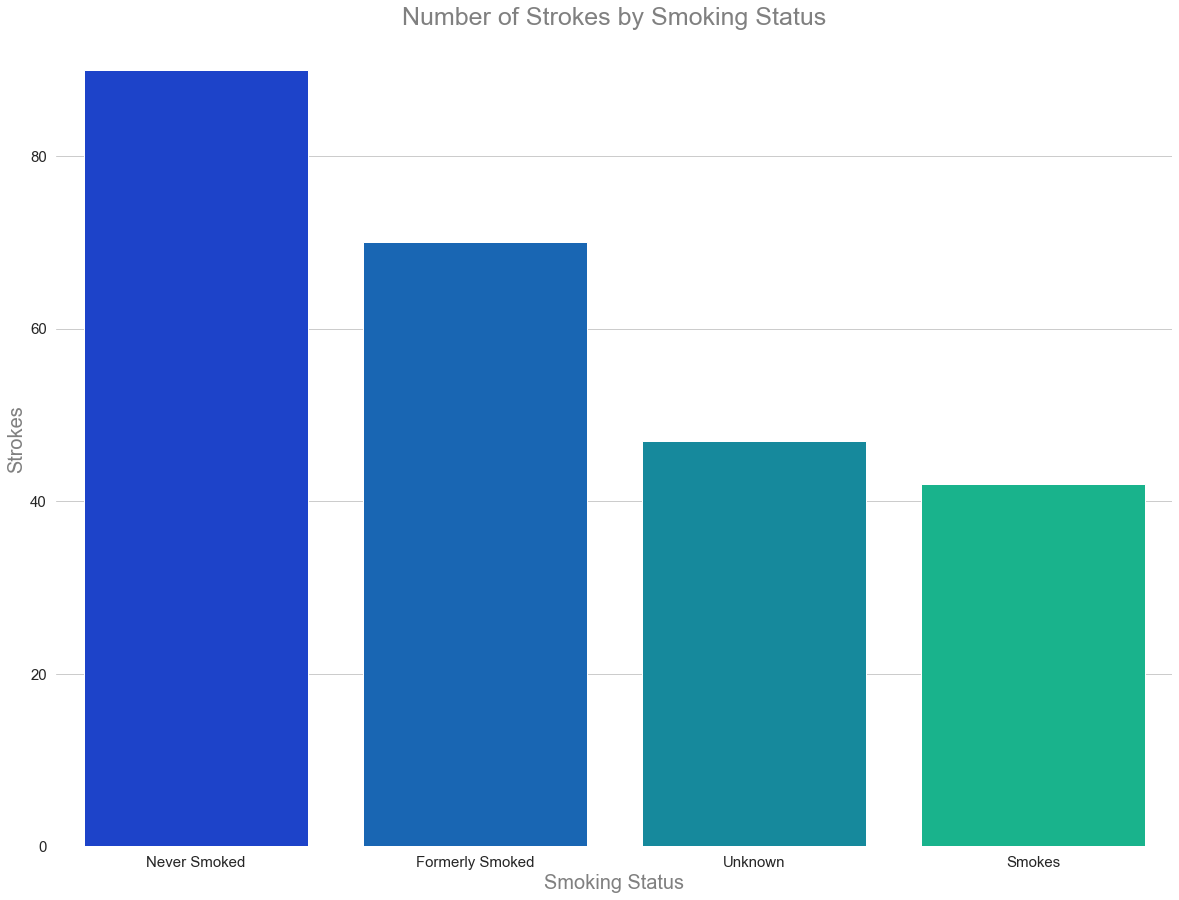

In [38]:
sns.barplot(x = 'smoking_status', y = 'stroke', data = aux1, palette = 'winter')
sns.despine(bottom = True, left = True)
plt.title('Number of Strokes by Smoking Status', size = 25, color = 'gray')
plt.xlabel("Smoking Status", size = 20, color = 'grey')
plt.ylabel("Strokes", size = 20, color = 'grey')
plt.xticks(np.arange(4), ['Never Smoked', 'Formerly Smoked', 'Unknown', 'Smokes'], size = 15)
plt.xticks(size = 15)
plt.yticks(size = 15);

#### Hipótese 4 - Crianças têm menos chances de ter AVC que os demais 

VERDADEIRA - Crianças tiveram MENOS AVC

#### Hipótese 5 - Idosos têm mais chances de ter AVC que os demais

VERDADEIRA - Idosos tiveram MAIS AVC

In [39]:
aux2 = df4[df4['stroke'] == 1][['age_group', 'stroke']].groupby('age_group').sum().reset_index().sort_values(by = 'stroke', ascending = False)
aux2

,age_group,stroke
2,elderly,181
0,adult,66
1,children,2


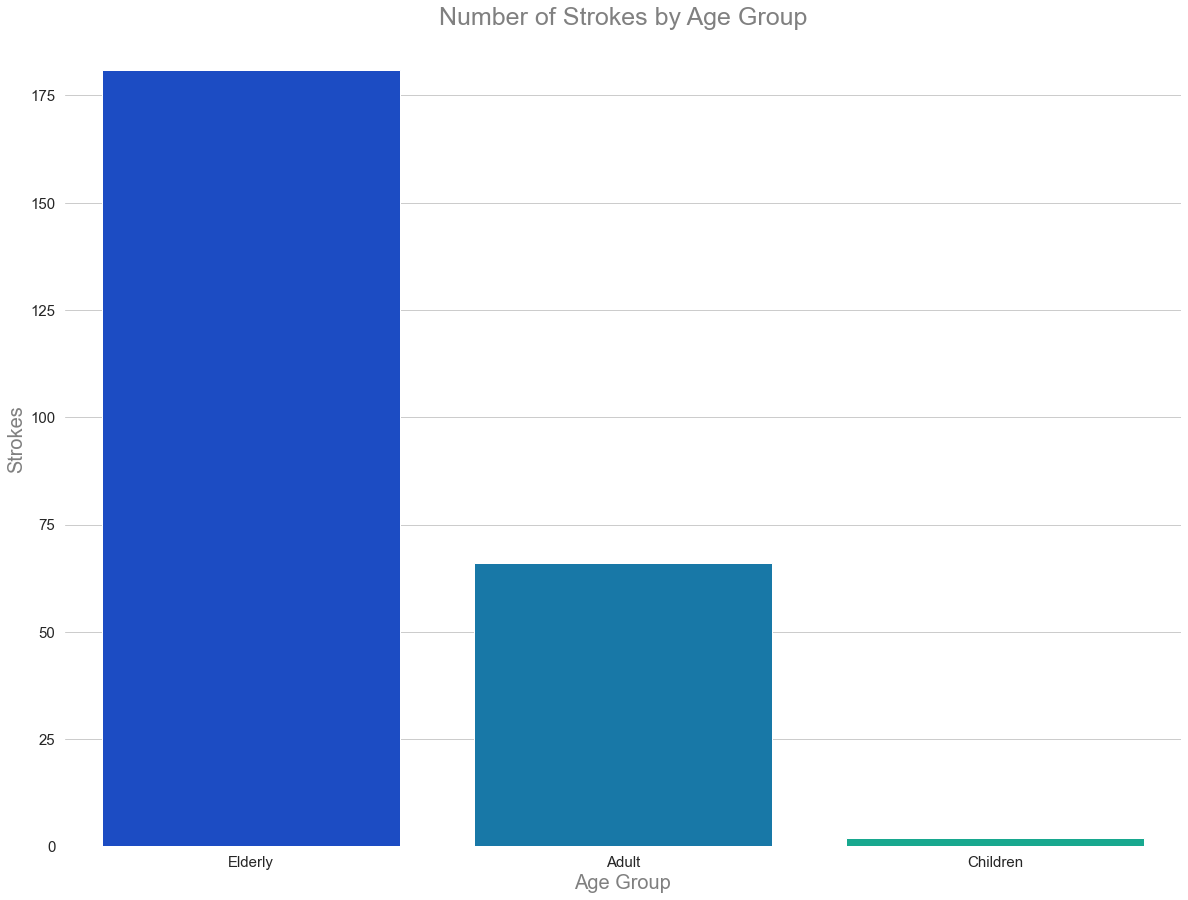

In [40]:
sns.barplot(x = 'age_group', y = 'stroke', data = aux2, palette = 'winter')
sns.despine(bottom = True, left = True)
plt.title('Number of Strokes by Age Group', size = 25, color = 'gray')
plt.xlabel("Age Group", size = 20, color = 'grey')
plt.ylabel("Strokes", size = 20, color = 'grey')
plt.xticks(np.arange(3), ['Elderly', 'Adult', 'Children'], size = 15)
plt.xticks(size = 15)
plt.yticks(size = 15);

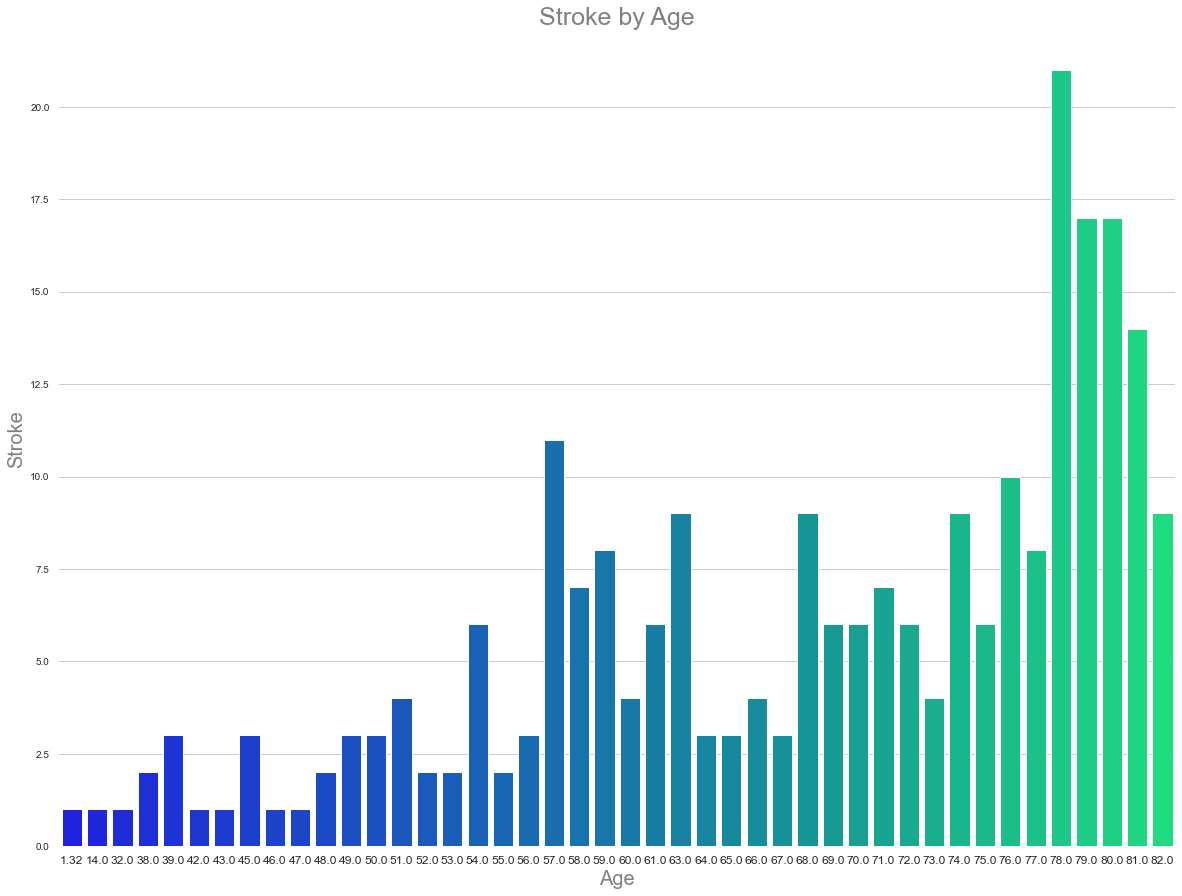

In [41]:
plt.figure(figsize(20,15))
aux3 = df4[df4['stroke'] == 1][['age', 'stroke']].groupby('age').sum().reset_index()
sns.barplot( x = 'age', y = 'stroke', data = aux3, palette = 'winter' );
plt.title('Stroke by Age', size = 25, color = 'grey')
sns.set_style("whitegrid")
sns.despine( bottom = True, left = True)
plt.xticks(size = 12)
plt.yticks(size = 10)
plt.xlabel("Age", size = 20, color = 'grey')
plt.ylabel("Stroke", size = 20, color = 'grey');

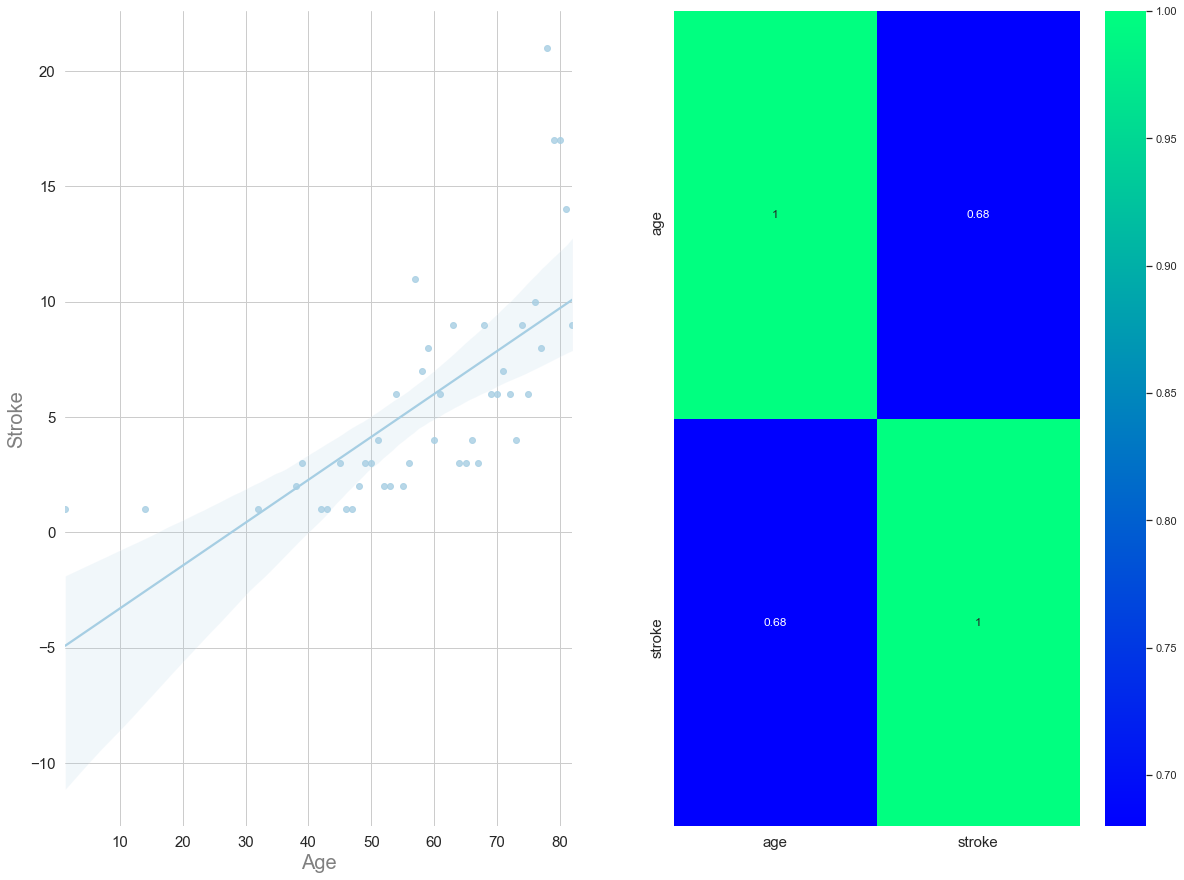

In [42]:
plt.subplot(1, 2, 1)
sns.regplot(x = 'age', y = 'stroke', data = aux3)
sns.despine(bottom = True, left = True)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.xlabel("Age", size = 20, color = 'grey')
plt.ylabel("Stroke", size = 20, color = 'grey')

plt.subplot(1, 2, 2)
sns.heatmap(aux3.corr( method='pearson' ), annot=True, cmap="winter")
sns.despine(bottom = True, left = True)
plt.xticks(size = 15)
plt.yticks(size = 15);

#### Hipótese 6 - Pessoas obesas têm mais chances de ter AVC que os demais

FALSA - Pessoas com sobrepeso tiveram MAIS AVC

#### Hipótese 7 - Pessoas com peso normal têm menos chances de ter AVC que os demais 

FALSA - Pessoas abaixo do peso tiveram MENOS AVC

In [43]:
aux4 = df4[df4['stroke'] == 1][['weight_status', 'stroke']].groupby('weight_status').sum().reset_index().sort_values(by = 'stroke', ascending = False)
aux4

,weight_status,stroke
2,overweight,115
1,obesity,98
0,normal_weight,35
3,underweight,1


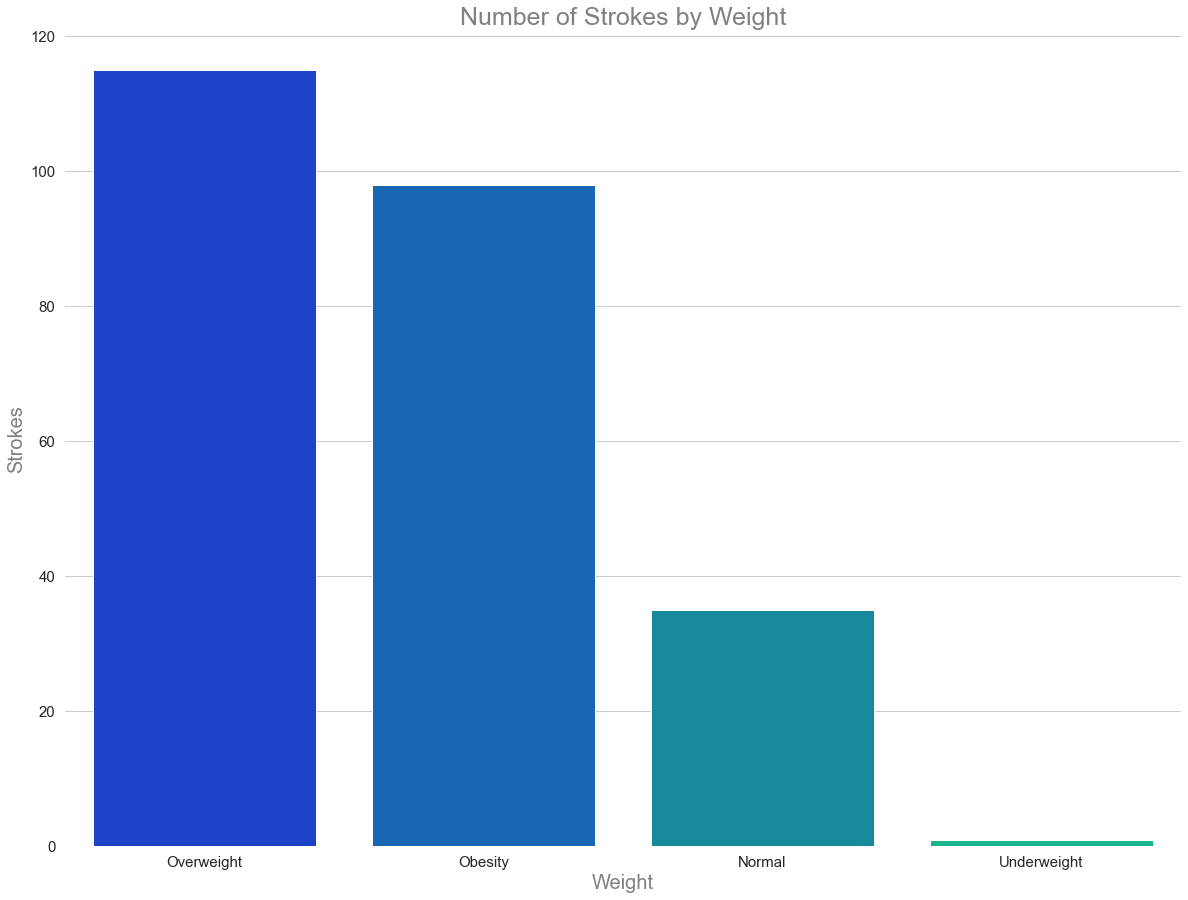

In [44]:
sns.barplot( x = 'weight_status', y = 'stroke', data = aux4, palette = 'winter' )
sns.despine( bottom = True, left = True)
plt.title( 'Number of Strokes by Weight', size = 25, color = 'gray')
plt.xlabel("Weight", size = 20, color = 'grey')
plt.ylabel("Strokes", size = 20, color = 'grey')
plt.xticks(np.arange(4), ['Overweight', 'Obesity', 'Normal', 'Underweight'], size = 15)
plt.xticks(size = 15)
plt.yticks(size = 15);

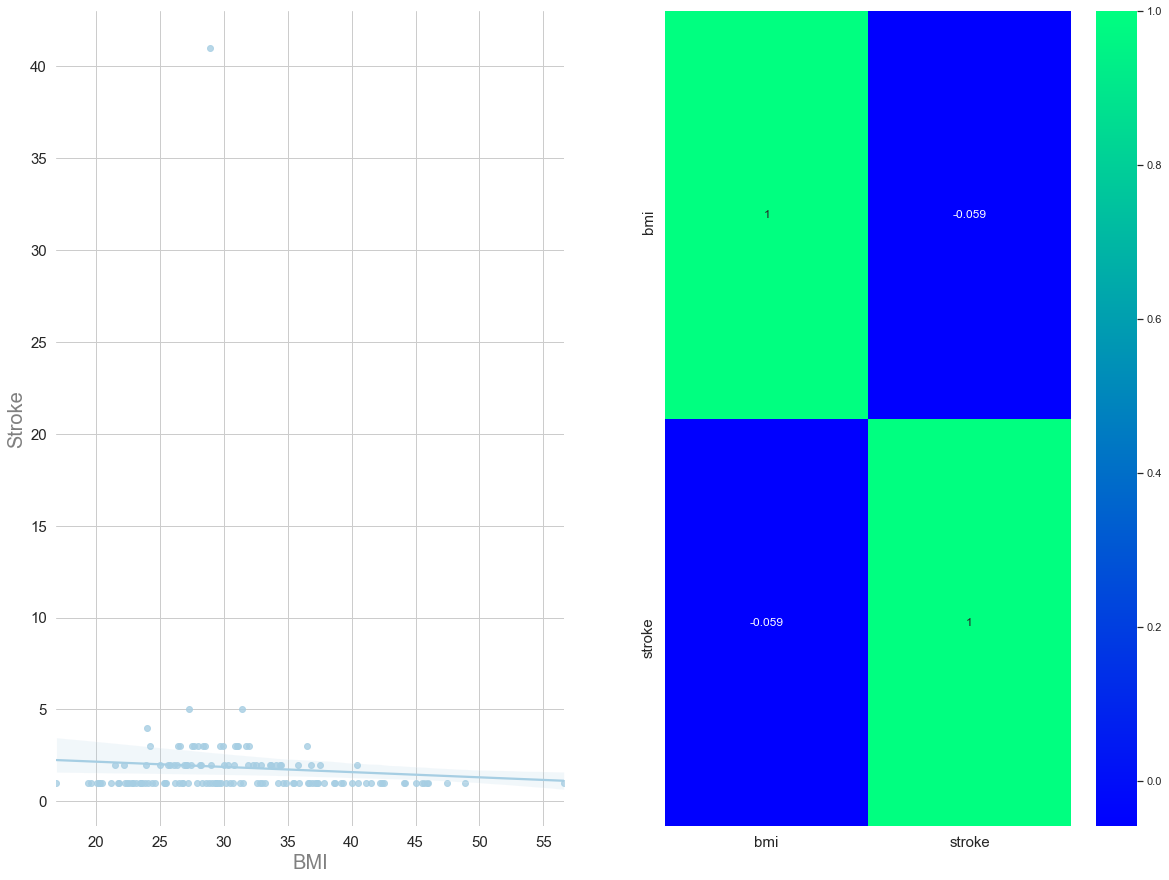

In [45]:
aux5 = df4[df4['stroke'] == 1][['bmi', 'stroke']].groupby('bmi').sum().reset_index()
plt.subplot(1, 2, 1)
sns.regplot(x = 'bmi', y = 'stroke', data = aux5)
sns.despine(bottom = True, left = True)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.xlabel("BMI", size = 20, color = 'grey')
plt.ylabel("Stroke", size = 20, color = 'grey')

plt.subplot(1, 2, 2)
sns.heatmap(aux5.corr( method='pearson' ), annot=True, cmap="winter")
sns.despine(bottom = True, left = True)
plt.xticks(size = 15)
plt.yticks(size = 15);

#### Hipótese 8 - Pessoas diabéticas têm mais chances de ter AVC que os demais

VERDADEIRA - Pessoas diabéticas tiveram MAIS AVC

#### Hipótese 9 - Pessoas com nível de glicose normal têm menos chances de ter AVC que os demais 

FALSA - Pessoas com nível de glicose baixa tiveram MENOS AVC

In [46]:
aux6 = df4[df4['stroke'] == 1][['glucose_status', 'stroke']].groupby('glucose_status').sum().reset_index().sort_values(by = 'stroke', ascending = False)
aux6

,glucose_status,stroke
0,diabetes,100
2,normal,85
3,prediabetes,37
1,low,27


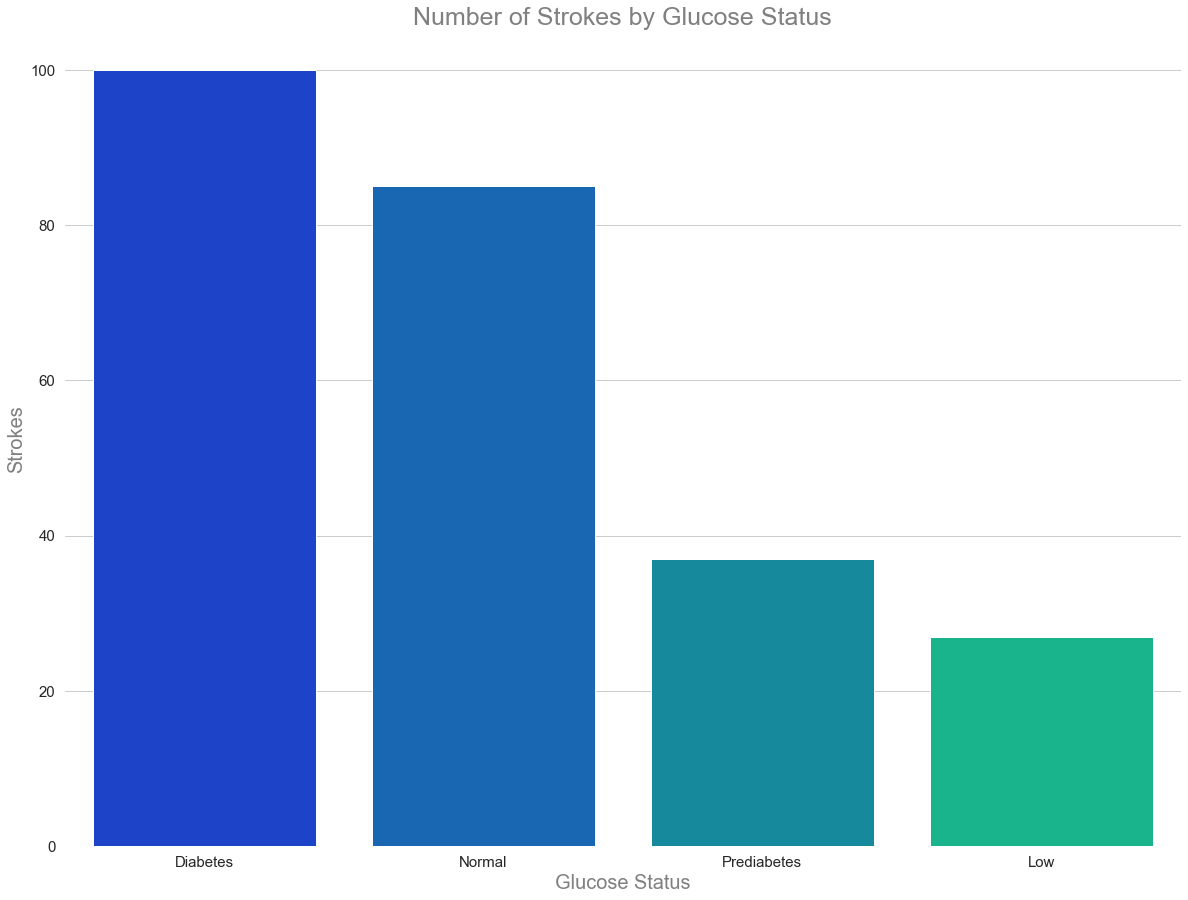

In [47]:
sns.barplot(x = 'glucose_status', y = 'stroke', data = aux6, palette = 'winter')
sns.despine(bottom = True, left = True)
plt.title('Number of Strokes by Glucose Status', size = 25, color = 'gray')
plt.xlabel("Glucose Status", size = 20, color = 'grey')
plt.ylabel("Strokes", size = 20, color = 'grey')
plt.xticks(np.arange(4), ['Diabetes', 'Normal', 'Prediabetes', 'Low'], size = 15)
plt.xticks(size = 15)
plt.yticks(size = 15);

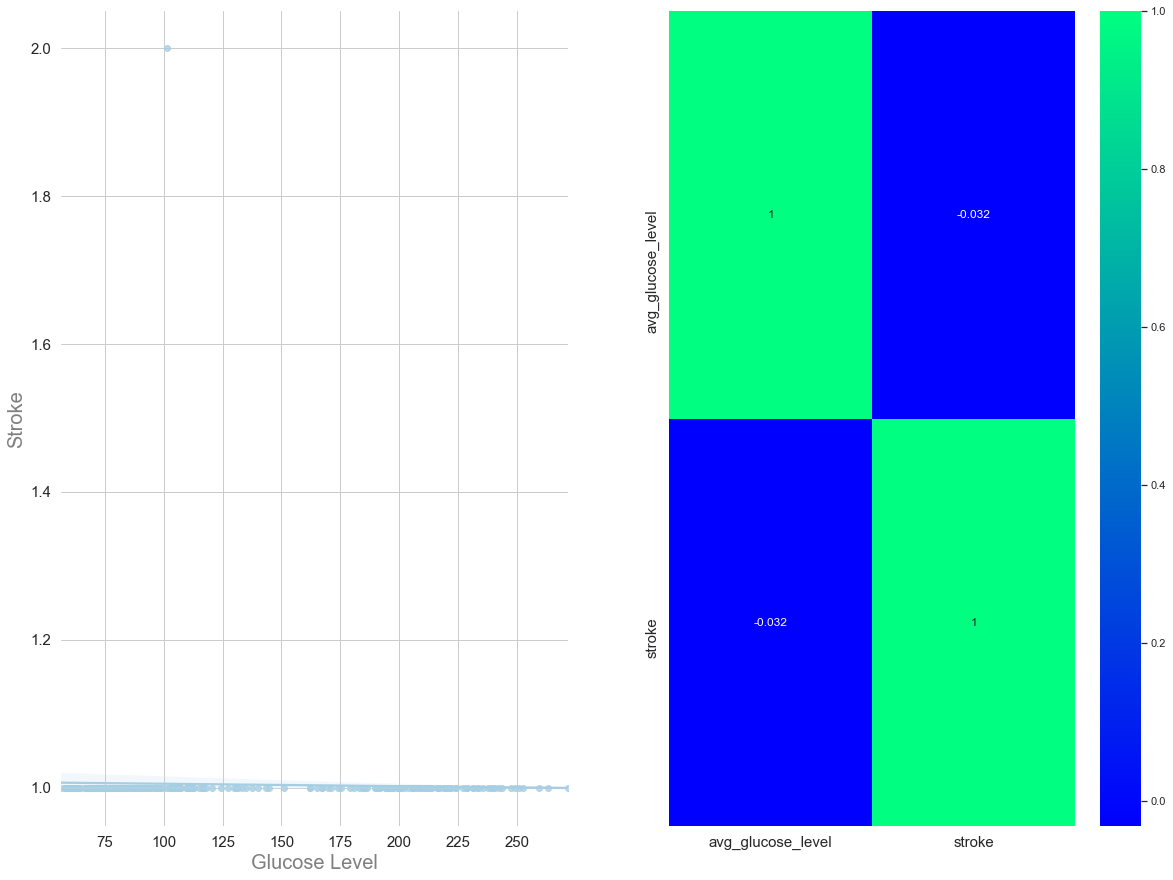

In [48]:
aux7 = df4[df4['stroke'] == 1][['avg_glucose_level', 'stroke']].groupby('avg_glucose_level').sum().reset_index()
plt.subplot(1, 2, 1)
sns.regplot(x = 'avg_glucose_level', y = 'stroke', data = aux7)
sns.despine(bottom = True, left = True)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.xlabel("Glucose Level", size = 20, color = 'grey')
plt.ylabel("Stroke", size = 20, color = 'grey')

plt.subplot(1, 2, 2)
sns.heatmap(aux7.corr( method='pearson' ), annot=True, cmap="winter")
sns.despine(bottom = True, left = True)
plt.xticks(size = 15)
plt.yticks(size = 15);

#### Hipótese 10 - Pessoas casadas têm mais chances de ter AVC 

VERDADEIRA - Pessoas casadas tiveram mais AVC

In [49]:
aux8 = df4[df4['stroke'] == 1][['ever_married', 'stroke']].groupby('ever_married').sum().reset_index().sort_values(by = 'stroke', ascending = False)
aux8

,ever_married,stroke
1,Yes,220
0,No,29


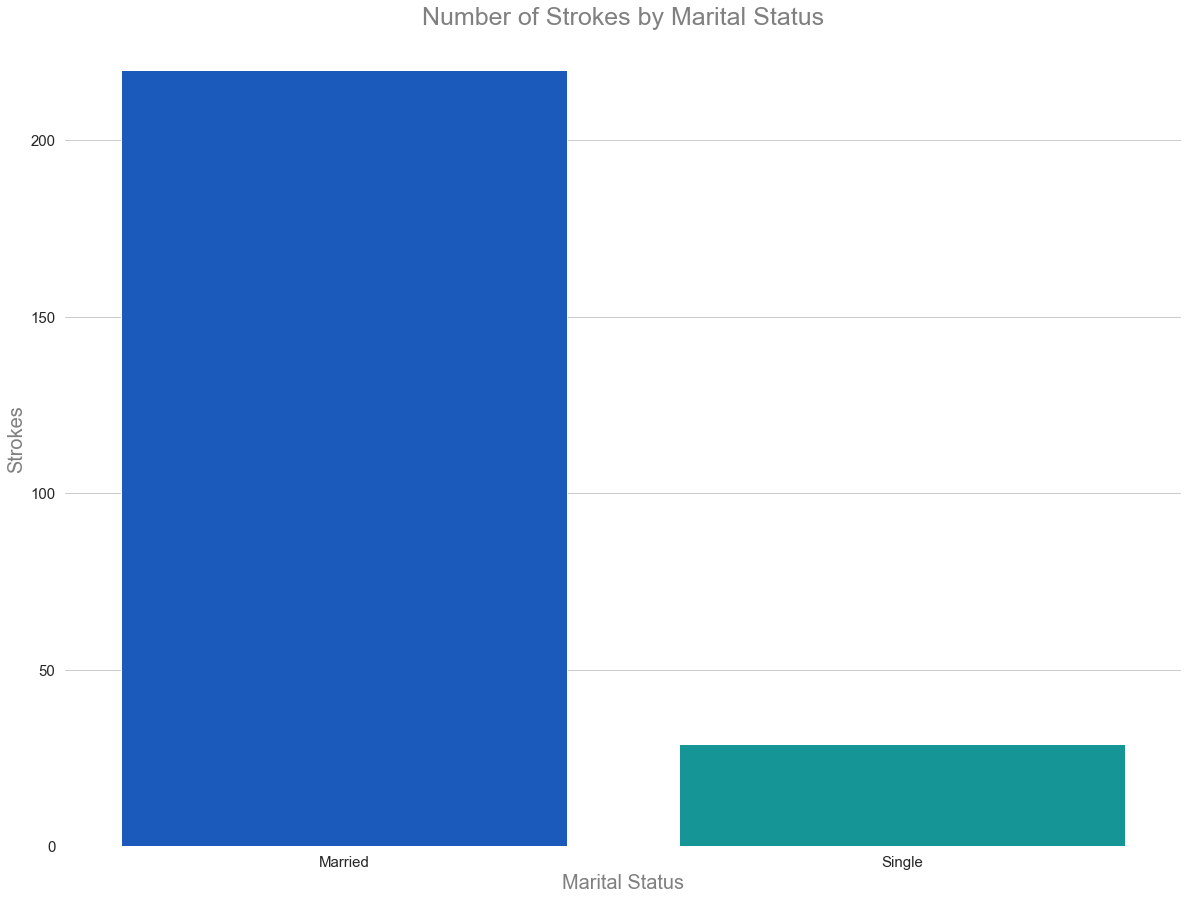

In [50]:
sns.barplot(x = 'ever_married', y = 'stroke', data = aux8, palette = 'winter')
sns.despine(bottom = True, left = True)
plt.title('Number of Strokes by Marital Status', size = 25, color = 'gray')
plt.xlabel("Marital Status", size = 20, color = 'grey')
plt.ylabel("Strokes", size = 20, color = 'grey')
plt.xticks(np.arange(2), ['Married', 'Single'], size = 15)
plt.xticks(size = 15)
plt.yticks(size = 15);

#### Hipótese 11 - Pessoas hipertensas têm mais chances de ter AVC 

FALSA - Pessoas hipertensas tiveram MENOS AVC

In [51]:
aux9 = df4[df4['stroke'] == 1][['hypertension', 'stroke']].groupby('hypertension').sum().reset_index()
aux9

,hypertension,stroke
0,0,183
1,1,66


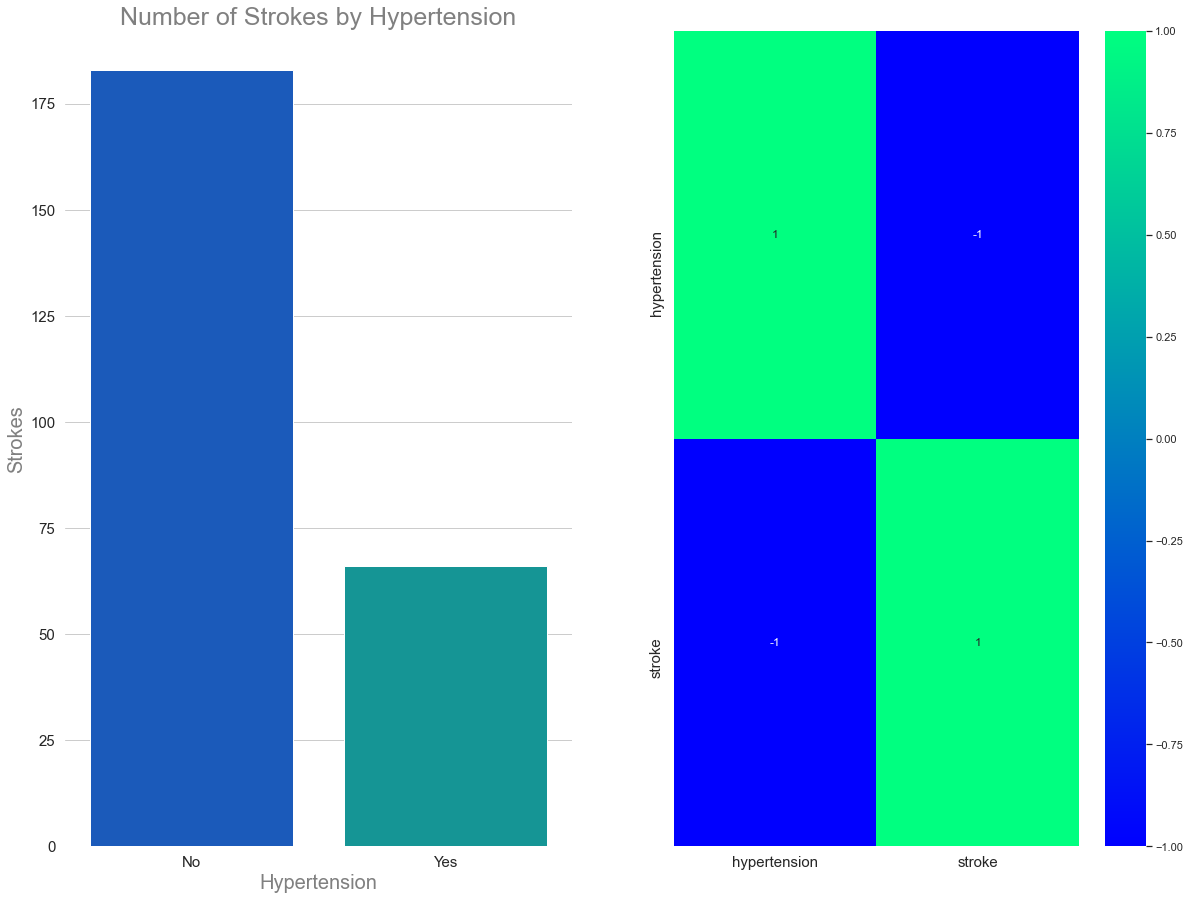

In [52]:
plt.subplot(1, 2, 1)
sns.barplot(x = 'hypertension', y = 'stroke', data = aux9, palette = 'winter')
sns.despine(bottom = True, left = True)
plt.title('Number of Strokes by Hypertension', size = 25, color = 'gray')
plt.xlabel("Hypertension", size = 20, color = 'grey')
plt.ylabel("Strokes", size = 20, color = 'grey')
plt.xticks(np.arange(2), ['No', 'Yes'], size = 15)
plt.xticks(size = 15)
plt.yticks(size = 15);

plt.subplot(1, 2, 2)
sns.heatmap( aux9.corr( method='pearson' ), annot=True, cmap="winter" )
sns.despine( bottom = True, left = True)
plt.xticks(size = 15)
plt.yticks(size = 15);

#### Hipótese 12 - Pessoas cardíacas têm mais chances de ter AVC 

FALSA - Pessoas cardíacas tiveram MENOS AVC

In [53]:
aux10 = df4[df4['stroke'] == 1][['heart_disease', 'stroke']].groupby('heart_disease').sum().reset_index()
aux10

,heart_disease,stroke
0,0,202
1,1,47


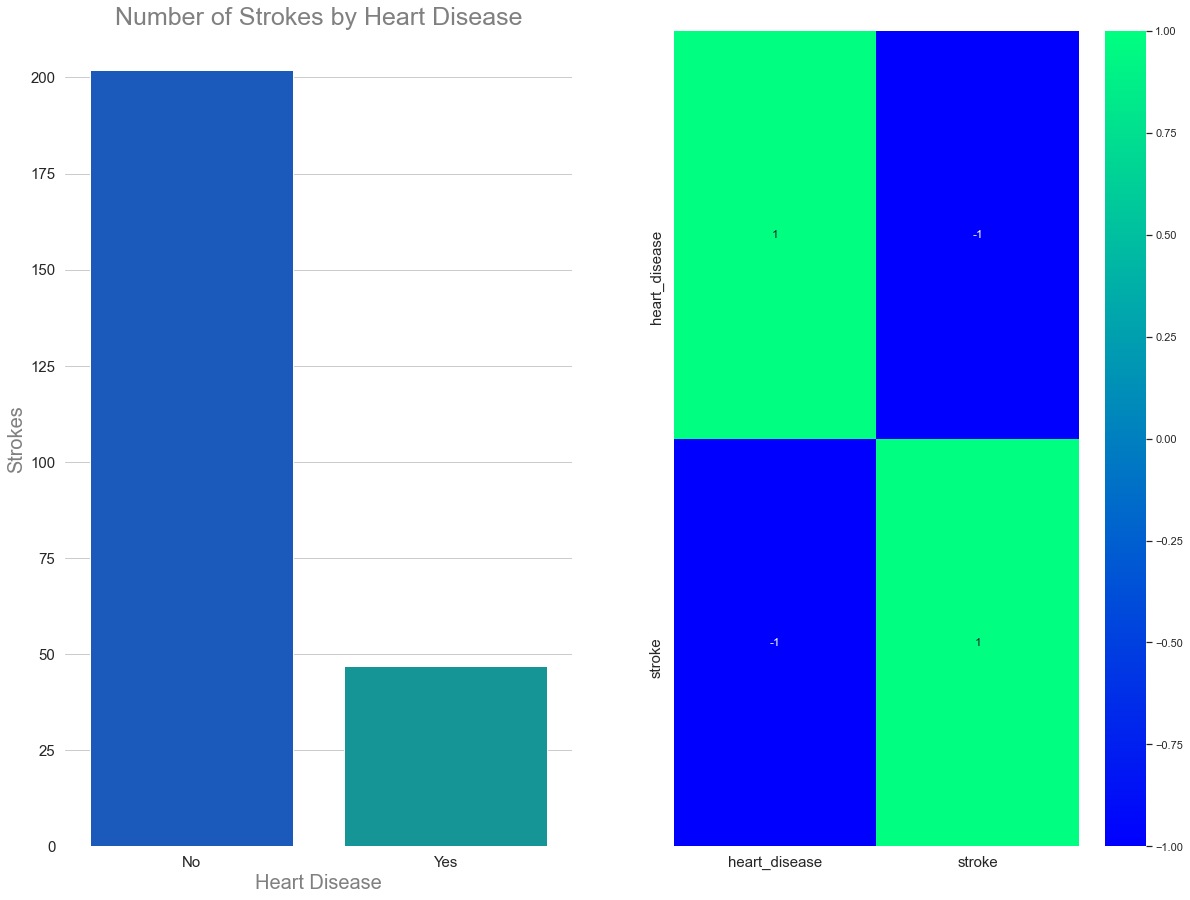

In [54]:
plt.subplot(1, 2, 1)
sns.barplot( x = 'heart_disease', y = 'stroke', data = aux10, palette = 'winter' )
sns.despine( bottom = True, left = True)
plt.title( 'Number of Strokes by Heart Disease', size = 25, color = 'gray')
plt.xlabel("Heart Disease", size = 20, color = 'grey')
plt.ylabel("Strokes", size = 20, color = 'grey')
plt.xticks(np.arange(2), ['No', 'Yes'], size = 15)
plt.xticks(size = 15)
plt.yticks(size = 15);

plt.subplot(1, 2, 2)
sns.heatmap( aux10.corr( method='pearson' ), annot=True, cmap="winter" )
sns.despine( bottom = True, left = True)
plt.xticks(size = 15)
plt.yticks(size = 15);

#### Hipótese 13 - Pessoas que moram na zona urbana têm mais chances de ter AVC 

VERDADEIRA - Pessoas que moram na zona urba tiveram MAIS AVC

In [55]:
aux11 = df4[df4['stroke'] == 1][['Residence_type', 'stroke']].groupby('Residence_type').sum().reset_index().sort_values(by = 'stroke', ascending = False)
aux11

,Residence_type,stroke
1,Urban,135
0,Rural,114


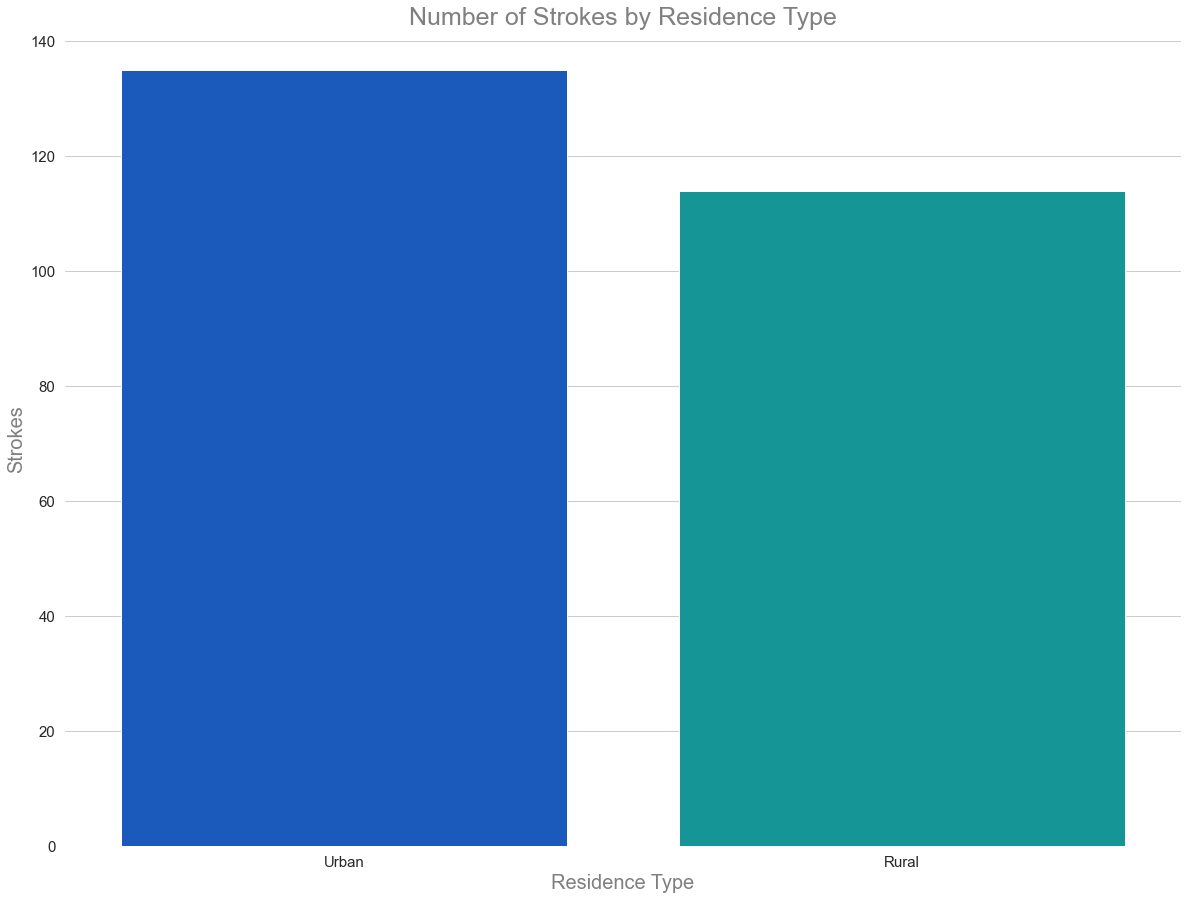

In [56]:
sns.barplot(x = 'Residence_type', y = 'stroke', data = aux11, palette = 'winter')
sns.despine(bottom = True, left = True)
plt.title('Number of Strokes by Residence Type', size = 25, color = 'gray')
plt.xlabel("Residence Type", size = 20, color = 'grey')
plt.ylabel("Strokes", size = 20, color = 'grey')
plt.xticks(np.arange(2), ['Urban', 'Rural'], size = 15)
plt.xticks(size = 15)
plt.yticks(size = 15);

#### Hipótese 14 - Pessoas empreendedoras têm mais chances de ter AVC que os demais 

FALSA - Pessoas que trabalham no setor privado tiveram MAIS AVC

#### Hipótese 15 - Crianças têm menos chances de ter AVC que os demais 

VERDADEIRA - Pessoas desempregadas porém que são crianças tiveram MENOS AVC

In [57]:
aux12 = df4[df4['stroke'] == 1][['work_type', 'stroke']].groupby('work_type').sum().reset_index().sort_values(by = 'stroke', ascending = False)
aux12

,work_type,stroke
1,Private,149
2,Self-employed,65
0,Govt_job,33
3,children,2


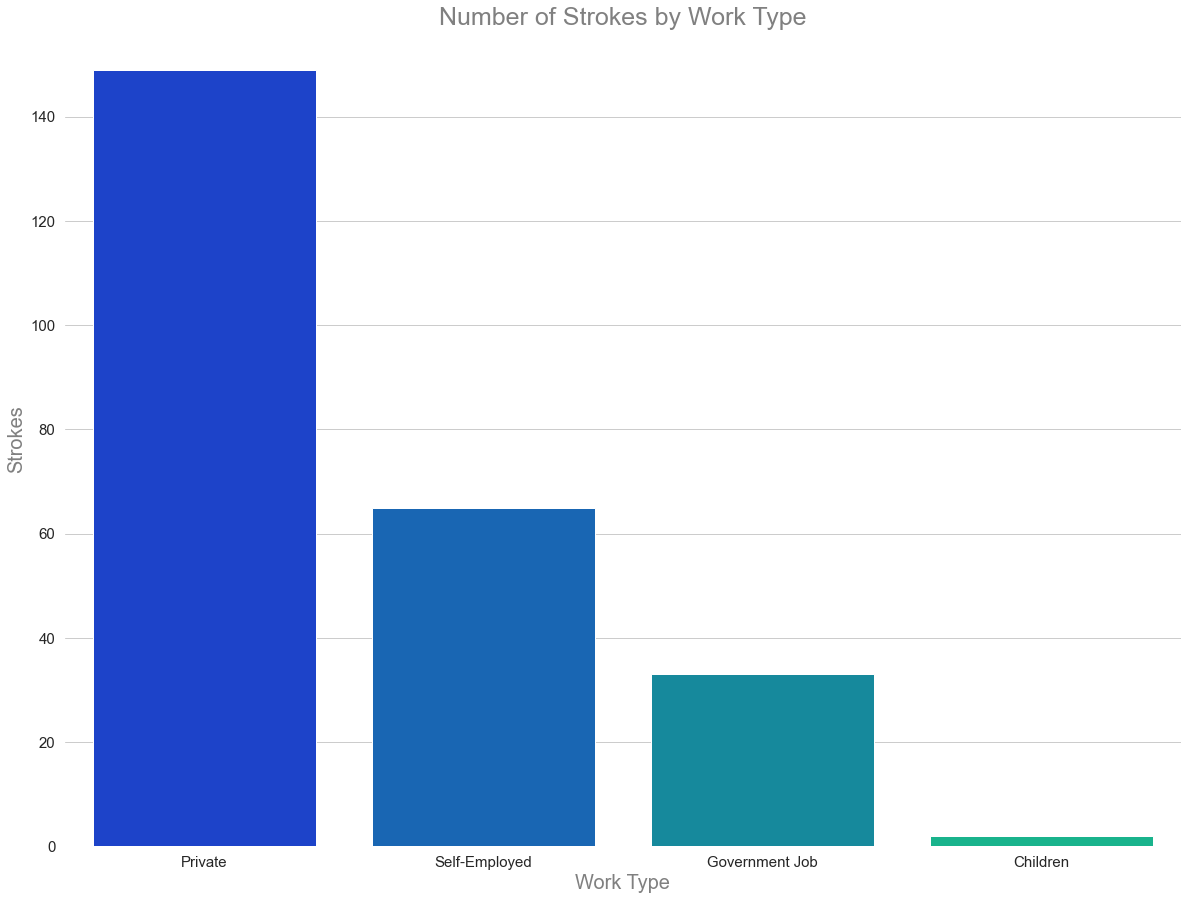

In [58]:
sns.barplot(x = 'work_type', y = 'stroke', data = aux12, palette = 'winter')
sns.despine(bottom = True, left = True)
plt.title('Number of Strokes by Work Type', size = 25, color = 'gray')
plt.xlabel("Work Type", size = 20, color = 'grey')
plt.ylabel("Strokes", size = 20, color = 'grey')
plt.xticks(np.arange(4), ['Private', 'Self-Employed', 'Government Job', 'Children'], size = 15)
plt.xticks(size = 15)
plt.yticks(size = 15);

Hipóteses

1 - Homens têm mais chances de ter AVC que mulheres

2 - Fumantes têm mais chances de ter AVC que os demais

3 - Pessoas que nunca fumaram têm menos chances de ter AVC que os demais

4 - Crianças têm menos chances de ter AVC que os demais

5 - Idosos têm mais chances de ter AVC que os demais

6 - Pessoas obesas têm mais chances de ter AVC que os demais

7 - Pessoas com peso normal têm menos chances de ter AVC que os demais

8 - Pessoas diabéticas têm mais chances de ter AVC que os demais

9 - Pessoas com glicose normal têm menos chances de ter AVC que os demais

10 - Pessoas casadas têm mais chances de ter AVC 

11 - Pessoas hipertensas têm mais chances de ter AVC

12 - Pessoas cardíacas têm mais chances de ter AVC

13 - Pessoas que moram na zona urbana têm mais chances de ter AVC

14 - Pessoas empreendedoras têm mais chances de ter AVC que os demais

15 - Crianças têm menos chances de ter AVC que os demais




In [59]:
tab =[['Hipóteses', 'Conclusão', 'Relevância'],
      ['H1', 'Falsa', 'Alta'],  
      ['H2', 'Falsa', 'Alta'],  
      ['H3', 'Falsa', 'Alta'],
      ['H4', 'Verdadeira', 'Baixa'],
      ['H5', 'Verdadeira', 'Baixa'],
      ['H6', 'Falsa', 'Alta'],
      ['H7', 'Falsa', 'Alta'],
      ['H8', 'Verdadeira', 'Alta'],
      ['H9', 'Falsa', 'Alta'],
      ['H10', 'Verdadeira', 'Alta'],
      ['H11', 'Falsa', 'Alta'],
      ['H12', 'Falsa', 'Alta'],
      ['H13', 'Verdadeira', 'Alta'],
      ['H14', 'Falsa', 'Baixa'],
      ['H15', 'Verdadeira', 'Alta'],
     ]  
print( tabulate( tab, headers='firstrow' ) )

Hipóteses    Conclusão    Relevância
-----------  -----------  ------------
H1           Falsa        Alta
H2           Falsa        Alta
H3           Falsa        Alta
H4           Verdadeira   Baixa
H5           Verdadeira   Baixa
H6           Falsa        Alta
H7           Falsa        Alta
H8           Verdadeira   Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Falsa        Alta
H12          Falsa        Alta
H13          Verdadeira   Alta
H14          Falsa        Baixa
H15          Verdadeira   Alta


### 4.3. Multivariate analysis

#### 4.3.1 Numerical Attributes

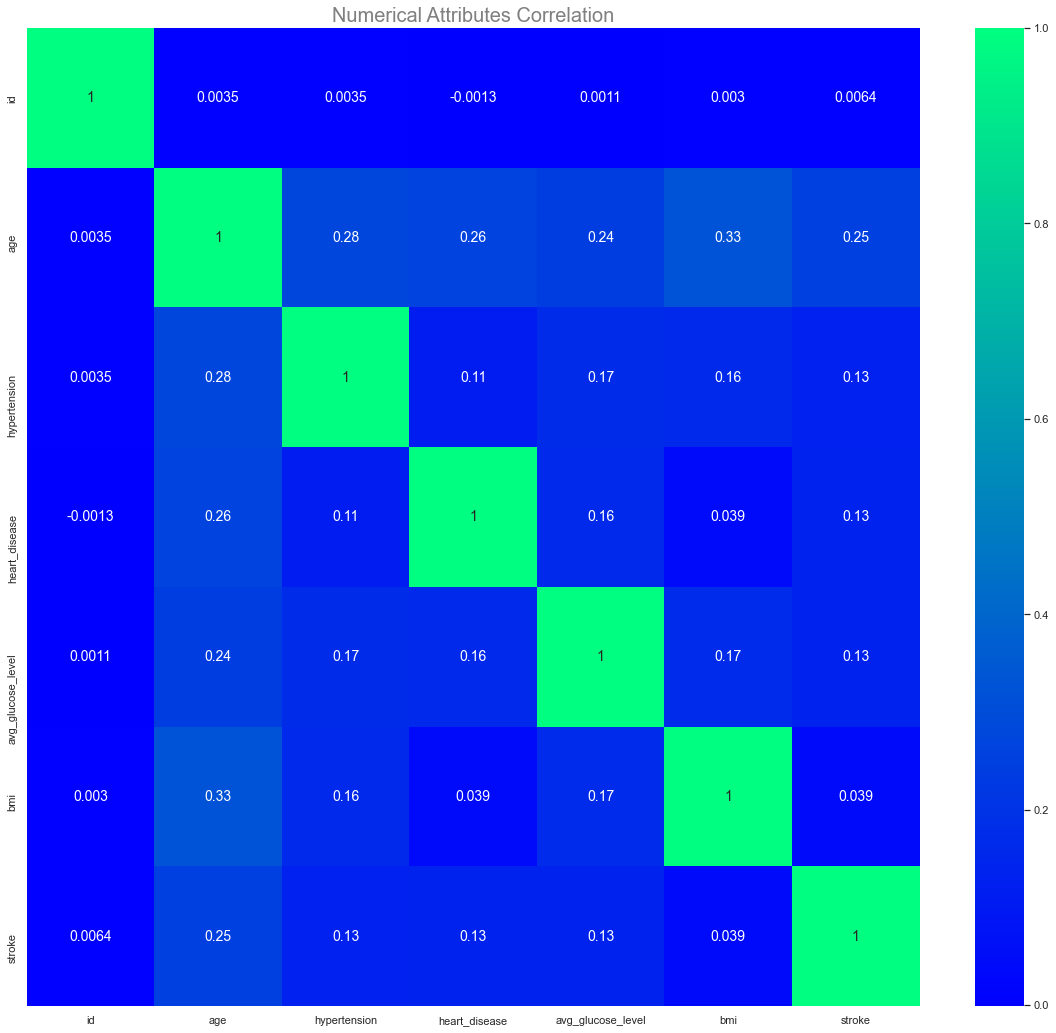

In [60]:
correlation = num_attr.corr(method='pearson')
plt.figure(figsize(20,18))
sns.heatmap(correlation, annot=True, annot_kws={"fontsize":14}, cmap='winter')
plt.title("Numerical Attributes Correlation", size=20, color='gray');

#### 4.3.2 Categorical Attributes

In [61]:
cat_attr.head()

,gender,ever_married,work_type,Residence_type,smoking_status
0,Male,Yes,Private,Urban,formerly smoked
1,Female,Yes,Self-employed,Rural,never smoked
2,Male,Yes,Private,Rural,never smoked
3,Female,Yes,Private,Urban,smokes
4,Female,Yes,Self-employed,Rural,never smoked


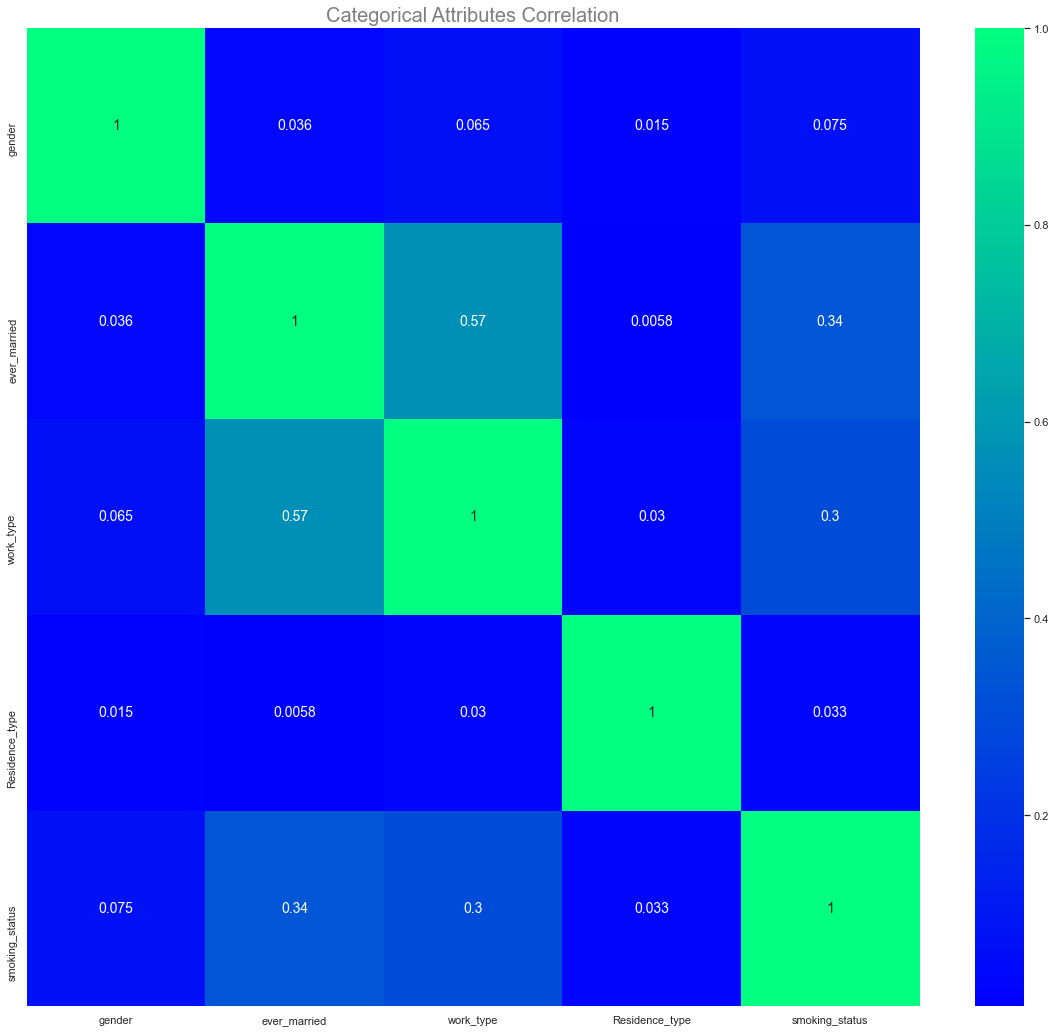

In [62]:
# Calculate cramer V
a1 = cramer_v(cat_attr['gender'], cat_attr['gender'])
a2 = cramer_v(cat_attr['gender'], cat_attr['ever_married'])
a3 = cramer_v(cat_attr['gender'], cat_attr['work_type'])
a4 = cramer_v(cat_attr['gender'], cat_attr['Residence_type'])
a5 = cramer_v(cat_attr['gender'], cat_attr['smoking_status'])

a6 = cramer_v(cat_attr['ever_married'], cat_attr['gender'])
a7 = cramer_v(cat_attr['ever_married'], cat_attr['ever_married'])
a8 = cramer_v(cat_attr['ever_married'], cat_attr['work_type'])
a9 = cramer_v(cat_attr['ever_married'], cat_attr['Residence_type'])
a10 = cramer_v(cat_attr['ever_married'], cat_attr['smoking_status'])

a11 = cramer_v(cat_attr['work_type'], cat_attr['gender'])
a12 = cramer_v(cat_attr['work_type'], cat_attr['ever_married'])
a13 = cramer_v(cat_attr['work_type'], cat_attr['work_type'])
a14 = cramer_v(cat_attr['work_type'], cat_attr['Residence_type'])
a15 = cramer_v(cat_attr['work_type'], cat_attr['smoking_status'])

a16 = cramer_v(cat_attr['Residence_type'], cat_attr['gender'])
a17 = cramer_v(cat_attr['Residence_type'], cat_attr['ever_married'])
a18 = cramer_v(cat_attr['Residence_type'], cat_attr['work_type'])
a19 = cramer_v(cat_attr['Residence_type'], cat_attr['Residence_type'])
a20 = cramer_v(cat_attr['Residence_type'], cat_attr['smoking_status'])

a21 = cramer_v(cat_attr['smoking_status'], cat_attr['gender'])
a22 = cramer_v(cat_attr['smoking_status'], cat_attr['ever_married'])
a23 = cramer_v(cat_attr['smoking_status'], cat_attr['work_type'])
a24 = cramer_v(cat_attr['smoking_status'], cat_attr['Residence_type'])
a25 = cramer_v(cat_attr['smoking_status'], cat_attr['smoking_status'])


# Final dataset
d = pd.DataFrame({'gender': [a1, a2, a3, a4, a5], 
                  'ever_married': [a6, a7, a8, a9, a10],
                  'work_type': [a11, a12, a13, a14, a15],
                  'Residence_type': [a16, a17, a18, a19, a20],
                  'smoking_status': [a21, a22, a23, a24, a25]})
d = d.set_index( d.columns )

plt.figure(figsize(20,18))
sns.heatmap(d, annot=True, annot_kws={"fontsize":14}, cmap='winter')
plt.title("Categorical Attributes Correlation", size=20, color='gray');

## 5.0. DATA PREPARATION

In [63]:
df5 = df4.copy()

In [64]:
df5.drop(['id'], axis=1, inplace=True)

In [65]:
df5['gender'].value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

In [66]:
# Como só se tem 1 'Other' em 'gender' provavelmente se trata de um erro, então será retirado
df5.drop(df5[df5['gender'] == 'Other'].index, axis = 0, inplace = True)

### 5.1. Scaling Numerical Variables

c:\Users\lucas\Documents\MeusProjetos\stroke_prediction\stroke_prediction_venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\lucas\Documents\MeusProjetos\stroke_prediction\stroke_prediction_venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\lucas\Documents\MeusProjetos\stroke_prediction\stroke_prediction_venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will

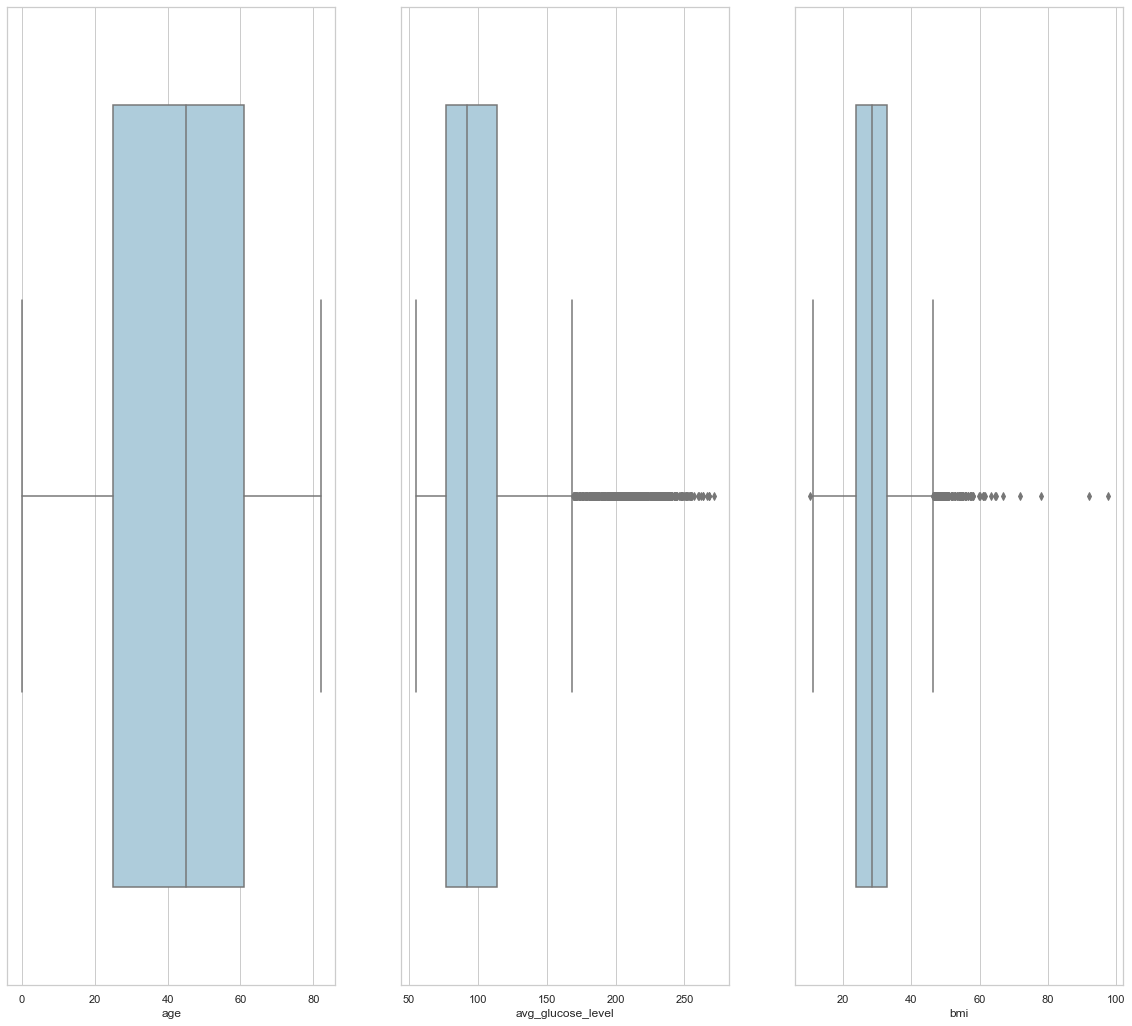

In [67]:
plt.subplot(1, 3, 1)
sns.boxplot(df5['age']);

plt.subplot(1, 3, 2)
sns.boxplot(df5['avg_glucose_level']);

plt.subplot(1, 3, 3)
sns.boxplot(df5['bmi']);

In [68]:
# Aplicarei Min-Max Scaler em 'age' que não possui outliers 
# e Robust Scaler em 'avg_glucose_level' e 'bmi' pois possuem bastante outliers
mms = MinMaxScaler()
rs = RobustScaler()

df5['age'] = rs.fit_transform(df5[['age']].values)

df5['avg_glucose_level'] = mms.fit_transform(df5[['avg_glucose_level']].values)

df5['bmi'] = mms.fit_transform(df5[['bmi']].values)

### 5.1. Encoding Categorical Variables

In [69]:
# Para 'gender', 'ever_married' e 'Residence_type' como só possuem 2 opcões de variáveis serão transformados por Label Encoder
le = LabelEncoder()

df5['gender'] = le.fit_transform(df5['gender'])

df5['ever_married'] = le.fit_transform(df5['ever_married'])

df5['Residence_type'] = le.fit_transform(df5['Residence_type'])

In [70]:
# 'work_type', 'smoking_status', 'weight_status', 'glucose_status' e 'age_group' possuem múltiplas variáveis então
# será aplicado frequency encoding

fe_wt = df5['work_type'].value_counts()/len(df5)
fe_wt.to_dict()
df5['work_type'] = df5['work_type'].map(fe_wt)

fe_ss = df5['smoking_status'].value_counts()/len(df5)
fe_ss.to_dict()
df5['smoking_status'] = df5['smoking_status'].map(fe_ss)

fe_ws = df5['weight_status'].value_counts()/len(df5)
fe_ws.to_dict()
df5['weight_status'] = df5['weight_status'].map(fe_ws)

fe_gs = df5['glucose_status'].value_counts()/len(df5)
fe_gs.to_dict()
df5['glucose_status'] = df5['glucose_status'].map(fe_gs)

fe_ag = df5['age_group'].value_counts()/len(df5)
fe_ag.to_dict()
df5['age_group'] = df5['age_group'].map(fe_ag)

In [71]:
df5.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,weight_status,glucose_status,age_group
0,1,0.611111,0,1,1,0.572323,1,0.801265,0.301260,0.173028,1,0.375807,0.195537,0.269329
1,0,0.444444,0,0,1,0.160305,0,0.679023,0.213058,0.370327,1,0.315130,0.195537,0.269329
2,1,0.972222,0,1,1,0.572323,0,0.234512,0.254296,0.370327,1,0.375807,0.191623,0.269329
3,0,0.111111,0,0,1,0.572323,1,0.536008,0.276060,0.154433,1,0.375807,0.195537,0.574868
4,0,0.944444,1,0,1,0.160305,0,0.549349,0.156930,0.370327,1,0.243100,0.195537,0.269329


## 6.0. FEATURE SELECTION

In [72]:
df6 = df5.copy()

### 6.1. Split into Train and Test datasets

In [73]:
x = df6.copy()
x.drop(['stroke'], axis=1, inplace=True)

In [74]:
y = df6['stroke'].copy()

In [75]:
x_train, x_test, y_train, y_test = ms.train_test_split(x, y, test_size = 0.3, random_state = 42)

In [76]:
# Boruta selecionou apenas 2 variaveis, não será utilizado
# # define RandomForestRegressor
# rf_clf = RandomForestClassifier(n_jobs=-1)

# # define Boruta
# boruta = BorutaPy(rf_clf, n_estimators='auto', verbose=2, random_state=42).fit(x_train.values, y_train.values.ravel())

In [77]:
# cols_selected = boruta.support_.tolist()
# cols_selected_boruta = x_train.iloc[:, cols_selected].columns.to_list()
# cols_selected_boruta

In [78]:
# x_train_boruta = x_train[cols_selected_boruta].copy()
# x_test_boruta = x_test[cols_selected_boruta].copy()

## 7.0. MACHINE LEARNING MODELING

In [79]:
df7 = df6.copy()

### 7.1. Balancing data for training

In [80]:
y_train.value_counts()

0    3416
1     160
Name: stroke, dtype: int64

In [81]:
 # defines the resampler
resampler = SMOTETomek(random_state = 42, n_jobs=-1)

# makes the balancing
x_train, y_train = resampler.fit_resample(x_train, y_train)

In [82]:
y_train.value_counts()

0    3406
1    3406
Name: stroke, dtype: int64

In [83]:
model1 = LogisticRegression(max_iter=220, random_state=42)
model2 = RandomForestClassifier(random_state=42)
model3 = xgb.XGBClassifier(random_state=42)
model1.fit(x_train, y_train)
model2.fit(x_train, y_train)
model3.fit(x_train, y_train)

c:\Users\lucas\Documents\MeusProjetos\stroke_prediction\stroke_prediction_venv\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:24:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [84]:
log_reg_predict = model1.predict(x_test)
print("Exatidão (Accuracy): {0:.4f}".format(metrics.accuracy_score(y_test, log_reg_predict)))

Exatidão (Accuracy): 0.7430


In [85]:
cv = StratifiedKFold(n_splits=10)

 # calculates the cross validation scores
cv_scores = cross_val_score(model1, x_train, y_train, cv = cv, scoring='precision', n_jobs=-1)

# prints the average precision and standard deviation of the scores
print("Average precision: %0.4f (+/- %0.4f)" % (cv_scores.mean(), cv_scores.std() * 2))


# calculates the cross validation scores
cv_scores = cross_val_score(model1, x_train, y_train, cv = cv, scoring='recall', n_jobs=-1)

# prints the average recall and standard deviation of the scores
print("\nAverage recall: %0.4f (+/- %0.4f)" % (cv_scores.mean(), cv_scores.std() * 2))


# calculates the cross validation scores
cv_scores = cross_val_score(model1, x_train, y_train, cv = cv, scoring='f1', n_jobs=-1)

# prints the average f1-score and standard deviation of the scores
print("\nAverage f1-score: %0.4f (+/- %0.4f)" % (cv_scores.mean(), cv_scores.std() * 2))


# calculates the cross validation scores
cv_scores = cross_val_score(model1, x_train, y_train, cv = cv, scoring='roc_auc', n_jobs=-1)

Average precision: 0.7714 (+/- 0.0323)

Average recall: 0.8462 (+/- 0.0319)

Average f1-score: 0.8069 (+/- 0.0198)


In [86]:
rf_class_predict = model2.predict(x_test)
print("Exatidão (Accuracy): {0:.4f}".format(metrics.accuracy_score(y_test, rf_class_predict)))

Exatidão (Accuracy): 0.9354


In [87]:
cv = StratifiedKFold(n_splits=10)

 # calculates the cross validation scores
cv_scores = cross_val_score(model2, x_train, y_train, cv = cv, scoring='precision', n_jobs=-1)

# prints the average precision and standard deviation of the scores
print("Average precision: %0.4f (+/- %0.4f)" % (cv_scores.mean(), cv_scores.std() * 2))


# calculates the cross validation scores
cv_scores = cross_val_score(model2, x_train, y_train, cv = cv, scoring='recall', n_jobs=-1)

# prints the average recall and standard deviation of the scores
print("\nAverage recall: %0.4f (+/- %0.4f)" % (cv_scores.mean(), cv_scores.std() * 2))


# calculates the cross validation scores
cv_scores = cross_val_score(model2, x_train, y_train, cv = cv, scoring='f1', n_jobs=-1)

# prints the average f1-score and standard deviation of the scores
print("\nAverage f1-score: %0.4f (+/- %0.4f)" % (cv_scores.mean(), cv_scores.std() * 2))


# calculates the cross validation scores
cv_scores = cross_val_score(model2, x_train, y_train, cv = cv, scoring='roc_auc', n_jobs=-1)

Average precision: 0.9787 (+/- 0.0170)

Average recall: 0.9669 (+/- 0.1930)

Average f1-score: 0.9699 (+/- 0.1132)


In [88]:
xgb_class_predict = model3.predict(x_test)
print("Exatidão (Accuracy): {0:.4f}".format(metrics.accuracy_score(y_test, xgb_class_predict)))

Exatidão (Accuracy): 0.9354


In [89]:
cv = StratifiedKFold(n_splits=10)

 # calculates the cross validation scores
cv_scores = cross_val_score(model3, x_train, y_train, cv = cv, scoring='precision', n_jobs=-1)

# prints the average precision and standard deviation of the scores
print("Average precision: %0.4f (+/- %0.4f)" % (cv_scores.mean(), cv_scores.std() * 2))


# calculates the cross validation scores
cv_scores = cross_val_score(model3, x_train, y_train, cv = cv, scoring='recall', n_jobs=-1)

# prints the average recall and standard deviation of the scores
print("\nAverage recall: %0.4f (+/- %0.4f)" % (cv_scores.mean(), cv_scores.std() * 2))


# calculates the cross validation scores
cv_scores = cross_val_score(model3, x_train, y_train, cv = cv, scoring='f1', n_jobs=-1)

# prints the average f1-score and standard deviation of the scores
print("\nAverage f1-score: %0.4f (+/- %0.4f)" % (cv_scores.mean(), cv_scores.std() * 2))


# calculates the cross validation scores
cv_scores = cross_val_score(model3, x_train, y_train, cv = cv, scoring='roc_auc', n_jobs=-1)

Average precision: 0.9799 (+/- 0.0147)

Average recall: 0.9581 (+/- 0.2458)

Average f1-score: 0.9639 (+/- 0.1511)


In [90]:
# Criando uma Confusion Matrix
print("Confusion Matrix")

print("{0}".format(metrics.confusion_matrix(y_test, log_reg_predict, labels = [1, 0])))
print("")

print("Classification Report")
print(metrics.classification_report(y_test, log_reg_predict, labels = [1, 0]))

Confusion Matrix
[[  66   23]
 [ 371 1073]]

Classification Report
              precision    recall  f1-score   support

           1       0.15      0.74      0.25        89
           0       0.98      0.74      0.84      1444

    accuracy                           0.74      1533
   macro avg       0.57      0.74      0.55      1533
weighted avg       0.93      0.74      0.81      1533



In [91]:
# Criando uma Confusion Matrix
print("Confusion Matrix")

print("{0}".format(metrics.confusion_matrix(y_test, rf_class_predict, labels = [1, 0])))
print("")

print("Classification Report")
print(metrics.classification_report(y_test, rf_class_predict, labels = [1, 0]))

Confusion Matrix
[[   2   87]
 [  12 1432]]

Classification Report
              precision    recall  f1-score   support

           1       0.14      0.02      0.04        89
           0       0.94      0.99      0.97      1444

    accuracy                           0.94      1533
   macro avg       0.54      0.51      0.50      1533
weighted avg       0.90      0.94      0.91      1533



In [92]:
# Criando uma Confusion Matrix
print("Confusion Matrix")

print("{0}".format(metrics.confusion_matrix(y_test, xgb_class_predict, labels = [1, 0])))
print("")

print("Classification Report")
print(metrics.classification_report(y_test, xgb_class_predict, labels = [1, 0]))

Confusion Matrix
[[   9   80]
 [  19 1425]]

Classification Report
              precision    recall  f1-score   support

           1       0.32      0.10      0.15        89
           0       0.95      0.99      0.97      1444

    accuracy                           0.94      1533
   macro avg       0.63      0.54      0.56      1533
weighted avg       0.91      0.94      0.92      1533

